---

# Keras Sequential Neural Network to predict the probability of a phishing URL


---

In [2]:
#load packages and libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
import sklearn as sk
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import *
from keras.utils.np_utils import *
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json


print("Done Loading")


Done Loading


## load data

In [3]:
full_df = pd.read_csv("https://raw.githubusercontent.com/jwaldroop/phishing-url-project/main/dataset_full.csv")

full_df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,17,0,0,...,0,0,0,7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.207316,0,60781,-1,-1,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,0,0,0,0,0,0,0,3,223,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0,...,0,0,0,9,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,165,0,3,0,0.499566,-1,36024,579,150,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.935901,0,4766,-1,-1,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,81,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,...,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410021,0,20454,-1,-1,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410761,0,53831,6998,306,1,2,1,3597,0,1,0,0,0,0


In [4]:
len(full_df[full_df.phishing == 1])

30647

In [5]:
len(full_df[full_df.phishing != 1])

58000

---

# unit testing to remove negative values (there cannot be a negative url length, etc.)

---

In [6]:
# Noticed a discrepancy in the data, some values are recorded as -1 even though it makes not practical sense, i.e. you can't have a negative quantity of a character
# This changes all -1 to 0
full_df.dtypes == 'int64'

def remove_negatives(full_df):
    full_df[full_df == -1] = 0
remove_negatives(full_df)

In [4]:
# unit test 
is_it_working = []
def data_cleaning_unit_test(column):
    did_it_work =  {'Yes':0 , 'No':0}
    for i in column:
        if i >= 0:
            did_it_work['Yes'] += 1
        elif i <0:
            did_it_work['No'] += 1
    if did_it_work['No'] > 0:
        print(column.name,'=', 'Not working')
    else:
        print(column.name,'=', 'It worked!')

In [5]:
for col in full_df.columns.tolist():
    data_cleaning_unit_test(full_df[col])

qty_dot_url = It worked!
qty_hyphen_url = It worked!
qty_underline_url = It worked!
qty_slash_url = It worked!
qty_questionmark_url = It worked!
qty_equal_url = It worked!
qty_at_url = It worked!
qty_and_url = It worked!
qty_exclamation_url = It worked!
qty_space_url = It worked!
qty_tilde_url = It worked!
qty_comma_url = It worked!
qty_plus_url = It worked!
qty_asterisk_url = It worked!
qty_hashtag_url = It worked!
qty_dollar_url = It worked!
qty_percent_url = It worked!
qty_tld_url = It worked!
length_url = It worked!
qty_dot_domain = It worked!
qty_hyphen_domain = It worked!
qty_underline_domain = It worked!
qty_slash_domain = It worked!
qty_questionmark_domain = It worked!
qty_equal_domain = It worked!
qty_at_domain = It worked!
qty_and_domain = It worked!
qty_exclamation_domain = It worked!
qty_space_domain = It worked!
qty_tilde_domain = It worked!
qty_comma_domain = It worked!
qty_plus_domain = It worked!
qty_asterisk_domain = It worked!
qty_hashtag_domain = It worked!
qty_dolla

In [6]:
full_df.describe()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.0,88647.0,88647.0,88647.000000,88647.0,88647.0,88647.0,88647.0,88647.0,88647.0,88647.0,88647.0,88647.0,88647.0,88647.000000,88647.000000,88647.000000,88647.000000,...,88647.0,88647.0,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.00000,88647.0,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000
mean,2.191343,0.328810,0.113879,1.281781,0.009329,0.205861,0.022133,0.140885,0.002944,0.001015,0.003226,0.002166,0.002786,0.004535,0.000508,0.001895,0.107505,1.047480,36.347615,1.870622,0.114578,0.000756,0.0,0.0,0.0,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.440590,18.560820,0.002267,0.004501,...,0.0,0.0,0.037192,3.279727,0.105181,0.037666,0.054023,0.028145,0.008449,0.189019,0.018027,0.127449,0.000496,0.000079,0.000056,0.001455,0.001636,0.00009,0.0,0.000384,0.054170,6.189459,0.024536,0.156531,0.018331,0.859983,0.147642,31131.225783,3389.951391,352.338917,1.186797,2.772412,1.742428,6159.927758,0.506447,0.422293,0.002425,0.003012,0.005482,0.345720
std,1.235636,1.119286,0.657767,1.893929,0.112568,0.954272,0.279652,0.924864,0.087341,0.072653,0.078127,0.075968,0.110904,0.301651,0.061655,0.099730,1.722625,0.254755,46.191590,0.705607,0.421957,0.032381,0.0,0.0,0.0,0.003359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.541244,6.598694,0.047564,0.066939,...,0.0,0.0,1.335428,13.432864,0.830999,0.505227,0.504926,0.411940,0.105608,0.900987,0.139828,0.849584,0.047019,0.014640,0.007510,0.063444,0.064147,0.01502,0.0,0.032561,0.963131,34.773196,0.154706,0.722705,0.134147,1.407413,0.354747,45261.452420,3043.859735,598.090471,0.796456,1.322999,1.706705,11465.556814,0.499961,0.689952,0.049188,0.054799,0.073841,0.475605
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

---

# NN on entire dataset

### (this can take a while to run depending on your computer resources)

---

In [7]:
y = full_df.iloc[:,-1]

X = full_df.iloc[:,0:111]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,0.000004,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.000042,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000008,0.000038,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.0,0.999934,0.000591,0.000797,0.000004,0.000023,0.000008,0.011480,0.000004,0.000000,0.0,0.0,0.0
39002,0.000777,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000259,0.003369,0.000777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000518,0.003369,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.0,0.730210,0.000000,0.680199,0.001036,0.001036,0.000518,0.064003,0.000259,0.000259,0.0,0.0,0.0
1732,0.000092,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000737,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000230,0.000737,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.698307,0.269674,0.016112,0.000046,0.000092,0.000046,0.662860,0.000000,0.000000,0.0,0.0,0.0
39668,0.000122,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000061,0.001588,0.000122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000550,0.001588,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.0,0.859057,0.261792,0.005926,0.000061,0.000122,0.000244,0.439823,0.000000,0.000061,0.0,0.0,0.0
82035,0.000054,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000027,0.000751,0.000054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000188,0.000751,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.795440,0.178787,0.007212,0.000027,0.000107,0.000107,0.579014,0.000000,0.000000,0.0,0.0,0.0


In [8]:
tf.keras.backend.clear_session() #clear tensorflow backend to help with memory leakage

nn_mod_1 = keras.Sequential([
                          layers.InputLayer(input_shape=[111]),                   # first layer - input - number of columns in X
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.Dropout(0.2),                                    # third layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fourth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.Dropout(0.2),                                    # fifth layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # sixth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.Dropout(0.20),                                   # seventh layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eighth layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.Dropout(0.2),                                    # ninth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # tenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.Dropout(0.2),                                    # eleventh layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # twelfth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.Dropout(0.40),                                   # thirteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # fourteenth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.Dropout(0.40),                                   # fifteenth layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # sixteenth layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.Flatten(),                                       # seventeenth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # eighteenth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

nn_mod_1.compile(
    optimizer='adam', #best optimizer for noise, easy computation
    loss='binary_crossentropy', #crossentropy between preds and val_y; preds are between 0 & 1 so we use binary
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), #binary accuracy between preds and val_y with 0.5 threshold
             tf.keras.metrics.AUC(), # measuring AUC (obviously) through internal measures of TP, TN, FP, FN
             ]
)

# early stopping callback will monitor the validation data's binary accuracy for it's maximum value
# & 25 epochs after reaching the maximum value, the model will stop running and restore the best layer weights measured.
# I don't actually want this to run for anywhere near 500 epochs but this gives it the flexibility to learn as long as needed

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)

# this will output a table of the layers, each layer output shape, and the parameters measured by the model
nn_mod_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7168      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [9]:
history1 = nn_mod_1.fit(train_X, train_y, validation_split=0.30, shuffle=True, batch_size= 175, epochs=500, callbacks = [earlystopping], workers=8)

# this fit method does not use the original validation split (25%) during model fitting to allow for more accurate evaluation and preditions later on
# the 75% training split (train_X, train_y) is split 70/30 during model fitting and each epoch the 70/30 split is, well, shuffled
# and there are 8 workers to *hopefully* help it run faster, in addition to the early stopping callback being applied

Epoch 1/500
266/266 [==============================] - 4s 9ms/step - loss: 0.6275 - binary_accuracy: 0.6548 - auc: 0.6108 - val_loss: 0.5662 - val_binary_accuracy: 0.7166 - val_auc: 0.7632
Epoch 2/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5572 - binary_accuracy: 0.7092 - auc: 0.7493 - val_loss: 0.5633 - val_binary_accuracy: 0.7282 - val_auc: 0.7710
Epoch 3/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5441 - binary_accuracy: 0.7189 - auc: 0.7582 - val_loss: 0.5480 - val_binary_accuracy: 0.7372 - val_auc: 0.7884
Epoch 4/500
266/266 [==============================] - 2s 6ms/step - loss: 0.5215 - binary_accuracy: 0.7340 - auc: 0.7840 - val_loss: 0.4894 - val_binary_accuracy: 0.7762 - val_auc: 0.8533
Epoch 5/500
266/266 [==============================] - 1s 6ms/step - loss: 0.4658 - binary_accuracy: 0.7745 - auc: 0.8357 - val_loss: 0.4422 - val_binary_accuracy: 0.8233 - val_auc: 0.9033
Epoch 6/500
266/266 [==============================] - 

In [ ]:
#turn model fit metric measures into a pandas dataframe

history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.298340,0.876291,0.930071,0.306239,0.892638,0.949530
std,0.079031,0.050985,0.052563,0.082248,0.051828,0.045229
min,0.247882,0.653989,0.693303,0.224036,0.659180,0.764524
25%,0.258570,0.885585,0.941027,0.253032,0.901710,0.959590
50%,0.267412,0.894776,0.948218,0.282801,0.909430,0.963853
75%,0.288674,0.897903,0.951484,0.315000,0.916587,0.965639
max,0.594974,0.903178,0.955421,0.570593,0.922741,0.970417


## evaluating the model and getting the overall model metrics following model fitting

In [ ]:
#tf.keras function to evaluate the model & record best metrics

train_acc = nn_mod_1.evaluate(train_X, train_y)  # evaluation w/ best measures of training data -- aka model fit
test_acc = nn_mod_1.evaluate(val_X, val_y)       # evaluation w/ best measures of validation/testing data -- the model hasn't seen this data before so super important!

693/693 [==============================] - 1s 1ms/step - loss: 0.2511 - binary_accuracy: 0.9205 - auc: 0.9650


In [ ]:
# display validation/testing evaluation metrics in a different way

dict(zip(nn_mod_1.metrics_names, test_acc))

{'auc': 0.9650113582611084,
 'binary_accuracy': 0.9205396771430969,
 'loss': 0.25112584233283997}

### graphs of the training vs. validation metrics across model fitting

Minimum validation loss (binary_crossentropy): 0.22403639554977417


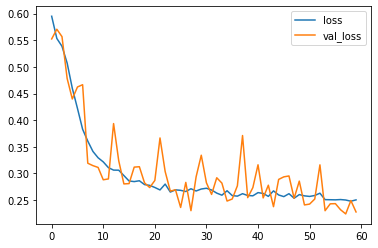

In [ ]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.970416784286499


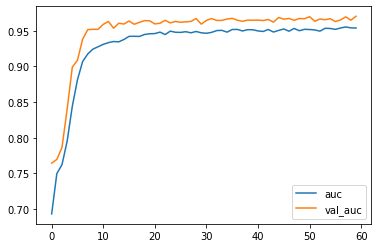

In [ ]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

##### wow that is a nice looking curve

Maximum validation binary accuracy: 0.9227414131164551


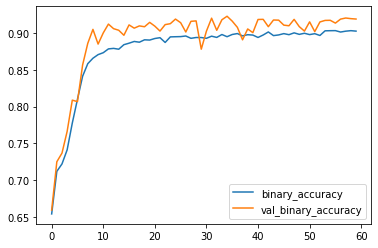

In [ ]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [ ]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.01956343650817871

## making predictions

In [ ]:
preds1 = nn_mod_1.predict(val_X) # this is tf.keras function & could be called on the entire dataset but it's not fair to ask the model to predict on data already seen
preds1

array([[0.8906534 ],
       [0.03351459],
       [0.4092056 ],
       ...,
       [0.24772266],
       [0.07768053],
       [0.8906534 ]], dtype=float32)

In [ ]:
# amount of predictions below the threshold of 0.5 - indicating a prediction of not phishing

len(preds1[preds1 <= 0.5])

13920

In [ ]:
# amount of predictions above the threshold of 0.5 - indicating a prediction of phishing

len(preds1[preds1 > 0.5])

8242

In [ ]:
# verify length of val_y - double check all preds within (0,1) limit

len(val_y)

22162

In [ ]:
# turn predictions into pandas dataframe

preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.890653
1,0.033515
2,0.409206
3,0.109818
4,0.680983


In [ ]:
# attach predictions to original validation data (val_X & val_y) for easier locating, plotting, etc.

preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,...,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
0,0.890653,1,62575,0.000276,0.000000,0.000000,0.000345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000069,0.003517,0.000207,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000345,...,0.0,0.0,0.0,0.0,0.000690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000007,0.000000,0.000000,0.138820,0.037377,0.000138,0.000138,0.000069,0.989602,0.000000,0.000000,0.0,0.0,0.0
1,0.033515,0,38126,0.000078,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000039,0.001012,0.000078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000272,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000098,0.000000,0.786588,0.260471,0.009454,0.000039,0.000078,0.000039,0.559770,0.000039,0.000000,0.0,0.0,0.0
2,0.409206,0,1617,0.000138,0.000069,0.000000,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000069,0.002348,0.000138,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000345,...,0.0,0.0,0.0,0.0,0.000967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000073,0.000000,0.921059,0.388661,0.014919,0.000138,0.000138,0.000345,0.018994,0.000069,0.000138,0.0,0.0,0.0
3,0.109818,0,8228,0.000041,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.000285,0.000041,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000050,0.000020,0.948421,0.119534,0.021672,0.000020,0.000041,0.000020,0.292813,0.000020,0.000020,0.0,0.0,0.0
4,0.680983,1,55594,0.054903,0.000000,0.027451,0.054903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027451,0.768639,0.027451,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109806,...,0.0,0.0,0.0,0.0,0.274514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109806,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.003822,0,65294,0.000261,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,0.001480,0.000261,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# this is a fun visualization of the model

#img_file = '/tmp/model_1.png'
#tf.keras.utils.plot_model(nn_mod_1, to_file=img_file, show_shapes=True)

# To-Do:

    - Work on getting SHAP to work with the format of the model
        - Tried to get this to work and the sklearn/keras Classifier wrapper isn't supported
    - Feature selection with sklearn wrapper ?
    - Predictions using the NN as a callable function compared to the build style above ---- Done
    - Clean up notebook w/ better comments lol
    
---

---
# NN in a more deployable format

### (again, this takes a long time to run)

In [16]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', #this needs to be changed to 'val_acc' if running in a Jupyter notebook (for some reason colab is different)
                                         patience = 15, restore_best_weights = True)

# building the model as a callable function for easier use with the sklearn wrapper

def phish_nn():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[111]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #had to slightly alter these parameters per the limitations on metric measuring in the sklearn wrapper
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8) #lowered epochs b/c w/cv there will be more epochs than in the original model fitting
  model.predict(val_X) #give the model the ability to predict as above
  model.evaluate(val_X, val_y) #give the model the ability to evaluate like was done above
  return model



---

# Model as Keras Classifier with Cross-Validation

## This is still a Keras Sequential model but it is also using a sklearn wrapper as a classifier model

# The NN as a function with the cross validation scoring and predictions takes a while to run  -- top 10 is the quickest

---

### Each model grouping has the same code as the others, just with the changes below

---



### the parameters that change across the models:

    - the input shape (because the inputs are different)
    - the early stopping callback is monitoring 'val_accuracy'
        - 'val_accuracy' in GoogleColab and 'val_acc' in Jupyter
    - the metric measured is now only accuracy b/c of issues with sklearn wrapper compatibility
    - decrease in epochs because of the way the cross validation is running ~ trying not avoid 12 hours per CV
    - increase in batch size for faster/easier computing
    - decrease in patience of early stopping callback

### cross-validation scores and predictions

    - 5 fold cross-validation on cv_scoring & cv_predictions

---

In [17]:
mod = KerasClassifier(build_fn=phish_nn,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

In [ ]:
cv_results=cross_val_score(mod,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 3s 7ms/step - loss: 0.6380 - accuracy: 0.6405 - val_loss: 0.5383 - val_accuracy: 0.7182
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5580 - accuracy: 0.7070 - val_loss: 0.5393 - val_accuracy: 0.7279
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5438 - accuracy: 0.7180 - val_loss: 0.5230 - val_accuracy: 0.7311
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5308 - accuracy: 0.7284 - val_loss: 0.4928 - val_accuracy: 0.7853
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4862 - accuracy: 0.7548 - val_loss: 0.4303 - val_accuracy: 0.7999
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4259 - accuracy: 0.7988 - val_loss: 0.3972 - val_accuracy: 0.8398
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3740 - accuracy: 0.8279 - val_loss: 0.3265 - val_accuracy: 0.8774
Epoch 

In [ ]:
print(round(cv_results.mean(), 4))

0.9085


In [ ]:
print(round(cv_results.std(), 4))

0.0067


In [ ]:
cv_results

array([0.89954877, 0.91009587, 0.91567487, 0.90196854, 0.91522366])

#### The cross validation results are very good news. With the lowest cv_score being 89.96% accuracy and the maximum being 91.57% accuracy, this is a positive note that the model is training and predicting correctly, with the cv_scores having a *slightly* lower average accuracy (90.85%) compared to the initial build and run of the NN (92.05%). It will be interesting to see the cross validation predictions.

In [ ]:
cv_preds = cross_val_predict(mod, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6294 - accuracy: 0.6447 - val_loss: 0.6065 - val_accuracy: 0.7193
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5612 - accuracy: 0.7074 - val_loss: 0.5678 - val_accuracy: 0.7263
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5425 - accuracy: 0.7217 - val_loss: 0.5877 - val_accuracy: 0.7199
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5358 - accuracy: 0.7255 - val_loss: 0.5362 - val_accuracy: 0.7426
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5082 - accuracy: 0.7381 - val_loss: 0.4934 - val_accuracy: 0.7703
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4569 - accuracy: 0.7778 - val_loss: 0.4523 - val_accuracy: 0.7942
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4143 - accuracy: 0.8111 - val_loss: 0.3967 - val_accuracy: 0.8520
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6257 - accuracy: 0.6514 - val_loss: 0.5903 - val_accuracy: 0.7200
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5581 - accuracy: 0.7043 - val_loss: 0.5518 - val_accuracy: 0.7244
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5447 - accuracy: 0.7159 - val_loss: 0.5533 - val_accuracy: 0.7302
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5313 - accuracy: 0.7244 - val_loss: 0.5409 - val_accuracy: 0.7427
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4973 - accuracy: 0.7463 - val_loss: 0.4746 - val_accuracy: 0.7691
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4504 - accuracy: 0.7909 - val_loss: 0.4672 - val_accuracy: 0.8111
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4102 - accuracy: 0.8191 - val_loss: 0.4269 - val_accuracy: 0.8463
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6206 - accuracy: 0.6513 - val_loss: 0.5694 - val_accuracy: 0.7175
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5572 - accuracy: 0.7077 - val_loss: 0.5873 - val_accuracy: 0.7264
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5422 - accuracy: 0.7207 - val_loss: 0.5477 - val_accuracy: 0.7338
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5232 - accuracy: 0.7309 - val_loss: 0.4844 - val_accuracy: 0.7824
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4573 - accuracy: 0.7806 - val_loss: 0.4421 - val_accuracy: 0.8043
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4220 - accuracy: 0.8060 - val_loss: 0.4637 - val_accuracy: 0.8144
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3868 - accuracy: 0.8321 - val_loss: 0.4015 - val_accuracy: 0.8621
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 7ms/step - loss: 0.6263 - accuracy: 0.6452 - val_loss: 0.5630 - val_accuracy: 0.7228
Epoch 2/50
266/266 [==============================] - 1s 6ms/step - loss: 0.5525 - accuracy: 0.7145 - val_loss: 0.5565 - val_accuracy: 0.7259
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5411 - accuracy: 0.7191 - val_loss: 0.5471 - val_accuracy: 0.7296
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5295 - accuracy: 0.7280 - val_loss: 0.5063 - val_accuracy: 0.7574
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4913 - accuracy: 0.7497 - val_loss: 0.4393 - val_accuracy: 0.7865
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4505 - accuracy: 0.7815 - val_loss: 0.4286 - val_accuracy: 0.8030
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8050 - val_loss: 0.4109 - val_accuracy: 0.8368
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6228 - accuracy: 0.6503 - val_loss: 0.5673 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5564 - accuracy: 0.7042 - val_loss: 0.5803 - val_accuracy: 0.7253
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5455 - accuracy: 0.7201 - val_loss: 0.5858 - val_accuracy: 0.7158
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5352 - accuracy: 0.7228 - val_loss: 0.5413 - val_accuracy: 0.7339
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5254 - accuracy: 0.7282 - val_loss: 0.4876 - val_accuracy: 0.7660
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4798 - accuracy: 0.7635 - val_loss: 0.4575 - val_accuracy: 0.7751
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4408 - accuracy: 0.7958 - val_loss: 0.4012 - val_accuracy: 0.8510
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cv_preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
len(cv_preds[cv_preds == 1])

35199

In [ ]:
cm = confusion_matrix(y, cv_preds)
print(cm)

[[51518  6482]
 [ 1930 28717]]


# neural network on URL attributes (table 1)

### (20 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url',
                   'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url',
                   'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url',
                   'length_url', 'email_in_url'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,email_in_url
5676,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,0
39002,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,0
1732,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,0
39668,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0
82035,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,0


### neural net - build/fit/predict

In [ ]:
tf.keras.backend.clear_session()

#neural net

table1_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[20]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table1_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table1_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table1_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.5745 - binary_accuracy: 0.7209 - auc: 0.7738 - val_loss: 0.3422 - val_binary_accuracy: 0.8353 - val_auc: 0.9512
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.3169 - binary_accuracy: 0.8684 - auc: 0.9374 - val_loss: 0.3037 - val_binary_accuracy: 0.8661 - val_auc: 0.9513
Epoch 3/500
266/266 [==============================] - 1s 5ms/step - loss: 0.2787 - binary_accuracy: 0.8820 - auc: 0.9453 - val_loss: 0.2908 - val_binary_accuracy: 0.8804 - val_auc: 0.9531
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.2733 - binary_accuracy: 0.8840 - auc: 0.9465 - val_loss: 0.2777 - val_binary_accuracy: 0.8887 - val_auc: 0.9540
Epoch 5/500
266/266 [==============================] - 2s 6ms/step - loss: 0.2692 - binary_accuracy: 0.8844 - auc: 0.9467 - val_loss: 0.2586 - val_binary_accuracy: 0.8910 - val_auc: 0.9546
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.250756,0.891133,0.952937,0.264266,0.892683,0.959750
std,0.038571,0.015748,0.017249,0.020358,0.010918,0.003238
min,0.233673,0.799996,0.849166,0.236486,0.835305,0.951205
25%,0.236118,0.890286,0.953659,0.251932,0.892109,0.958815
50%,0.240125,0.894862,0.956931,0.257829,0.894916,0.960680
75%,0.250152,0.897849,0.958915,0.268100,0.897674,0.961842
max,0.474800,0.899246,0.959894,0.342210,0.901584,0.964359


In [ ]:
train_acc = table1_nn.evaluate(train_X, train_y)
test_acc = table1_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.2449 - binary_accuracy: 0.8989 - auc: 0.9594


In [ ]:
dict(zip(table1_nn.metrics_names, test_acc))

{'auc': 0.9594447016716003,
 'binary_accuracy': 0.8989260792732239,
 'loss': 0.24493859708309174}

Minimum validation loss (binary_crossentropy): 0.23648624122142792


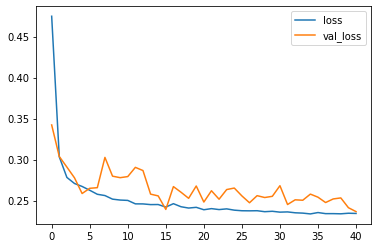

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.9643588662147522


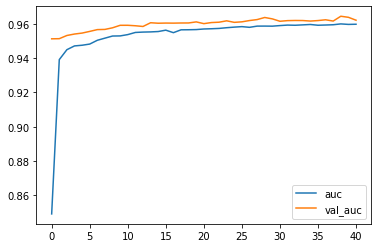

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.901584267616272


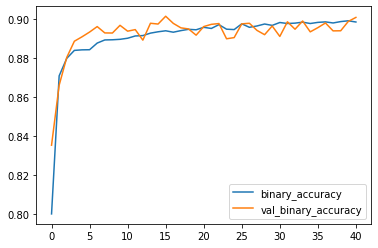

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table1_nn.predict(val_X)
preds1

array([[0.7504779 ],
       [0.01452219],
       [0.58809745],
       ...,
       [0.01452219],
       [0.01452219],
       [0.5692853 ]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

13589

In [ ]:
len(preds1[preds1 >= 0.5])

8573

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns=['preds'])

preds_df.head()

,preds
0,0.750478
1,0.014522
2,0.588097
3,0.014522
4,0.532912


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,email_in_url
0,0.750478,1,62575,4,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,51,0
1,0.014522,0,38126,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0
2,0.588097,0,1617,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,34,0
3,0.014522,0,8228,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,0
4,0.532912,1,55594,2,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.014522,0,65294,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,0
22158,0.014522,0,10038,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,0
22159,0.014522,0,43642,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23,0
22160,0.014522,0,73632,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0


# NN on URL attributes (table 1) [model as function]

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url',
                   'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url',
                   'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url',
                   'length_url', 'email_in_url'] 

X = full_df[features_table1]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,email_in_url
5676,0.089803,0.0,0.0,0.089803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089803,0.987829,0.0
39002,0.224231,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074744,0.971666,0.0
1732,0.123797,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061898,0.990375,0.0
39668,0.076640,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038320,0.996322,0.0
82035,0.071202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035601,0.996826,0.0


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_1():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[20]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod1 = KerasClassifier(build_fn=phish_nn_1,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_1=cross_val_score(mod1,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.5891 - accuracy: 0.6881 - val_loss: 0.3395 - val_accuracy: 0.8876
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3511 - accuracy: 0.8832 - val_loss: 0.3480 - val_accuracy: 0.8889
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3282 - accuracy: 0.8859 - val_loss: 0.3593 - val_accuracy: 0.8797
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8870 - val_loss: 0.3584 - val_accuracy: 0.8797
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3021 - accuracy: 0.8896 - val_loss: 0.4257 - val_accuracy: 0.8756
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2948 - accuracy: 0.8881 - val_loss: 0.4323 - val_accuracy: 0.8748
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2888 - accuracy: 0.8906 - val_loss: 0.3668 - val_accuracy: 0.8824
Epoch 

In [ ]:
print(round(cv_results_1.mean(), 4))

0.8919


In [ ]:
print(round(cv_results_1.std(), 4))

0.0009


In [ ]:
cv_results_1

In [ ]:
cv1_preds = cross_val_predict(mod1, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6106 - accuracy: 0.6690 - val_loss: 0.3452 - val_accuracy: 0.8832
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3634 - accuracy: 0.8828 - val_loss: 0.3454 - val_accuracy: 0.8853
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3374 - accuracy: 0.8863 - val_loss: 0.3257 - val_accuracy: 0.8894
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3158 - accuracy: 0.8870 - val_loss: 0.4184 - val_accuracy: 0.8777
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3023 - accuracy: 0.8913 - val_loss: 0.3898 - val_accuracy: 0.8844
Epoch 6/50
266/266 [==============================] - 1s 6ms/step - loss: 0.2892 - accuracy: 0.8909 - val_loss: 0.3412 - val_accuracy: 0.8828
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2859 - accuracy: 0.8894 - val_loss: 0.4007 - val_accuracy: 0.8860
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 5ms/step - loss: 0.6072 - accuracy: 0.6751 - val_loss: 0.3431 - val_accuracy: 0.8838
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3612 - accuracy: 0.8852 - val_loss: 0.3748 - val_accuracy: 0.8899
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3296 - accuracy: 0.8895 - val_loss: 0.3320 - val_accuracy: 0.8910
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3237 - accuracy: 0.8862 - val_loss: 0.3728 - val_accuracy: 0.8907
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3061 - accuracy: 0.8868 - val_loss: 0.3375 - val_accuracy: 0.8941
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2976 - accuracy: 0.8890 - val_loss: 0.3221 - val_accuracy: 0.8933
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2915 - accuracy: 0.8882 - val_loss: 0.3340 - val_accuracy: 0.8973
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.5903 - accuracy: 0.6876 - val_loss: 0.3395 - val_accuracy: 0.8857
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3589 - accuracy: 0.8801 - val_loss: 0.3409 - val_accuracy: 0.8804
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3357 - accuracy: 0.8814 - val_loss: 0.3542 - val_accuracy: 0.8828
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3147 - accuracy: 0.8878 - val_loss: 0.3403 - val_accuracy: 0.8780
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3032 - accuracy: 0.8864 - val_loss: 0.3475 - val_accuracy: 0.8851
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2959 - accuracy: 0.8891 - val_loss: 0.4383 - val_accuracy: 0.8672
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2907 - accuracy: 0.8867 - val_loss: 0.3539 - val_accuracy: 0.8735
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.5971 - accuracy: 0.6784 - val_loss: 0.3470 - val_accuracy: 0.8859
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3594 - accuracy: 0.8849 - val_loss: 0.3496 - val_accuracy: 0.8818
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3299 - accuracy: 0.8902 - val_loss: 0.3874 - val_accuracy: 0.8816
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3155 - accuracy: 0.8896 - val_loss: 0.3405 - val_accuracy: 0.8840
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2987 - accuracy: 0.8910 - val_loss: 0.3574 - val_accuracy: 0.8924
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2966 - accuracy: 0.8884 - val_loss: 0.3259 - val_accuracy: 0.8934
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2904 - accuracy: 0.8847 - val_loss: 0.3406 - val_accuracy: 0.8770
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.5798 - accuracy: 0.6981 - val_loss: 0.3385 - val_accuracy: 0.8860
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3520 - accuracy: 0.8881 - val_loss: 0.3478 - val_accuracy: 0.8868
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3245 - accuracy: 0.8870 - val_loss: 0.3572 - val_accuracy: 0.8869
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3164 - accuracy: 0.8876 - val_loss: 0.3690 - val_accuracy: 0.8806
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3075 - accuracy: 0.8871 - val_loss: 0.3503 - val_accuracy: 0.8924
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2923 - accuracy: 0.8891 - val_loss: 0.3310 - val_accuracy: 0.8924
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8878 - val_loss: 0.3462 - val_accuracy: 0.8848
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm1 = confusion_matrix(y, cv1_preds)
print(cm1)

[[48872  9128]
 [ 1153 29494]]


In [ ]:
'''dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]
param_grid = dict(dropout_rate=dropout_rate)
grid1 = GridSearchCV(estimator=mod1, param_grid=param_grid, cv=10)
grid_result1 = grid1.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
for params, mean_score, scores in grid_result1.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'''

# neural network on dataset attributes based on domain URL (table 2)

### (21 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain',
                   'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain',
                   'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain
5676,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,0,0
39002,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,13,0,0
1732,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0
39668,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,26,0,0
82035,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,28,0,0


In [ ]:
X.shape

(88647, 21)

In [ ]:
tf.keras.backend.clear_session()

#neural net

table2_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[21]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table2_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table2_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table2_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 8ms/step - loss: 0.6673 - binary_accuracy: 0.6329 - auc: 0.5016 - val_loss: 0.6406 - val_binary_accuracy: 0.6592 - val_auc: 0.6125
Epoch 2/500
266/266 [==============================] - 2s 6ms/step - loss: 0.6349 - binary_accuracy: 0.6551 - auc: 0.5897 - val_loss: 0.6041 - val_binary_accuracy: 0.6592 - val_auc: 0.7060
Epoch 3/500
266/266 [==============================] - 2s 6ms/step - loss: 0.6108 - binary_accuracy: 0.6508 - auc: 0.6778 - val_loss: 0.6089 - val_binary_accuracy: 0.6592 - val_auc: 0.7175
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5934 - binary_accuracy: 0.6623 - auc: 0.7053 - val_loss: 0.6016 - val_binary_accuracy: 0.7087 - val_auc: 0.7296
Epoch 5/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5807 - binary_accuracy: 0.7131 - auc: 0.7210 - val_loss: 0.5596 - val_binary_accuracy: 0.7247 - val_auc: 0.7406
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.546830,0.738396,0.750385,0.540109,0.744266,0.766182
std,0.019015,0.019392,0.033776,0.018086,0.018062,0.021565
min,0.535144,0.648316,0.506675,0.527051,0.659180,0.612541
25%,0.537947,0.739713,0.748606,0.532541,0.745789,0.761926
50%,0.540744,0.744279,0.759433,0.535062,0.749524,0.773008
75%,0.548001,0.746353,0.764124,0.540335,0.751579,0.776602
max,0.652841,0.749909,0.767385,0.640649,0.755339,0.780659


In [ ]:
train_acc = table2_nn.evaluate(train_X, train_y)
test_acc = table2_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.5342 - binary_accuracy: 0.7532 - auc: 0.7706


In [ ]:
dict(zip(table2_nn.metrics_names, test_acc))

{'auc': 0.7705593109130859,
 'binary_accuracy': 0.7532262206077576,
 'loss': 0.5342294573783875}

Minimum validation loss (binary_crossentropy): 0.5270507335662842


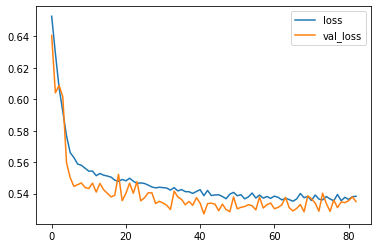

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.7806586027145386


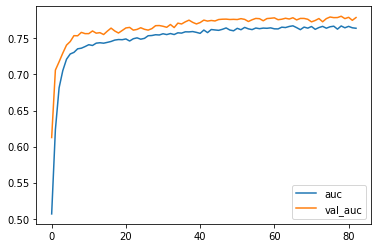

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.7553394436836243


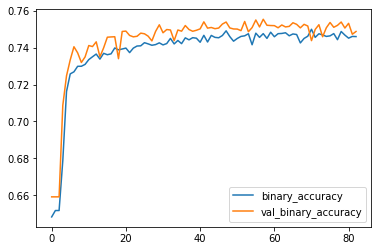

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table2_nn.predict(val_X)
preds1

array([[0.18894672],
       [0.27802005],
       [0.19450375],
       ...,
       [0.1833435 ],
       [0.4506697 ],
       [0.218847  ]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

15746

In [ ]:
len(preds1[preds1 >= 0.5])

6416

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.188947
1,0.278020
2,0.194504
3,0.235895
4,0.634766


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain
0,0.188947,1,62575,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,17,0,0
1,0.278020,0,38126,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,26,0,0
2,0.194504,0,1617,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0
3,0.235895,0,8228,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,0,0
4,0.634766,1,55594,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.170489,0,65294,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,17,0,0
22158,0.185905,0,10038,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0,0
22159,0.183343,0,43642,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,23,0,1
22160,0.450670,0,73632,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,26,0,0


In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# NN on domain URL attributes (table 2) [model as function]

In [ ]:
y = full_df['phishing']

features_table2 = ['qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain',
                   'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain',
                   'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain'] 

X = full_df[features_table2]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain
5676,0.097590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195180,0.975900,0.0,0.0
39002,0.222375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148250,0.963624,0.0,0.0
1732,0.118470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296174,0.947758,0.0,0.0
39668,0.072500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326250,0.942499,0.0,0.0
82035,0.069130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.241955,0.967822,0.0,0.0


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_2():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[21]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod2 = KerasClassifier(build_fn=phish_nn_2,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_2=cross_val_score(mod2,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6531 - accuracy: 0.6492 - val_loss: 0.6182 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6167 - accuracy: 0.6519 - val_loss: 0.6194 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6038 - accuracy: 0.6528 - val_loss: 0.6075 - val_accuracy: 0.6898
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5952 - accuracy: 0.6943 - val_loss: 0.6040 - val_accuracy: 0.6957
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5891 - accuracy: 0.6964 - val_loss: 0.5979 - val_accuracy: 0.7151
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5895 - accuracy: 0.7028 - val_loss: 0.5961 - val_accuracy: 0.6989
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5858 - accuracy: 0.7041 - val_loss: 0.5819 - val_accuracy: 0.7199
Epoch 

In [ ]:
print(round(cv_results_2.mean(), 4))

0.7305


In [ ]:
print(round(cv_results_2.std(), 4))

0.0039


In [ ]:
cv2_preds = cross_val_predict(mod2, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6548 - accuracy: 0.6422 - val_loss: 0.6108 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6146 - accuracy: 0.6535 - val_loss: 0.6344 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5982 - accuracy: 0.6723 - val_loss: 0.5947 - val_accuracy: 0.7041
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5957 - accuracy: 0.6898 - val_loss: 0.5951 - val_accuracy: 0.6970
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5880 - accuracy: 0.7033 - val_loss: 0.6000 - val_accuracy: 0.7125
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5861 - accuracy: 0.7094 - val_loss: 0.5888 - val_accuracy: 0.7166
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5877 - accuracy: 0.7027 - val_loss: 0.5815 - val_accuracy: 0.7157
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6572 - accuracy: 0.6367 - val_loss: 0.6126 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.6193 - accuracy: 0.6540 - val_loss: 0.6181 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.6006 - accuracy: 0.6610 - val_loss: 0.6018 - val_accuracy: 0.7081
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5885 - accuracy: 0.7016 - val_loss: 0.6041 - val_accuracy: 0.7224
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5879 - accuracy: 0.7054 - val_loss: 0.5858 - val_accuracy: 0.7179
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5886 - accuracy: 0.7034 - val_loss: 0.5828 - val_accuracy: 0.6998
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5852 - accuracy: 0.7094 - val_loss: 0.5801 - val_accuracy: 0.7002
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6539 - accuracy: 0.6502 - val_loss: 0.6167 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6229 - accuracy: 0.6515 - val_loss: 0.6091 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6110 - accuracy: 0.6537 - val_loss: 0.6123 - val_accuracy: 0.6847
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6014 - accuracy: 0.6892 - val_loss: 0.5958 - val_accuracy: 0.6980
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5915 - accuracy: 0.6991 - val_loss: 0.6018 - val_accuracy: 0.7065
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5871 - accuracy: 0.7029 - val_loss: 0.5853 - val_accuracy: 0.7199
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5818 - accuracy: 0.7065 - val_loss: 0.5788 - val_accuracy: 0.7171
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6513 - accuracy: 0.6546 - val_loss: 0.6189 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6194 - accuracy: 0.6536 - val_loss: 0.6064 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6039 - accuracy: 0.6557 - val_loss: 0.6072 - val_accuracy: 0.6957
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.6908 - val_loss: 0.5895 - val_accuracy: 0.6964
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5897 - accuracy: 0.6995 - val_loss: 0.5859 - val_accuracy: 0.7115
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5855 - accuracy: 0.7032 - val_loss: 0.5882 - val_accuracy: 0.7168
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5838 - accuracy: 0.7077 - val_loss: 0.5912 - val_accuracy: 0.7035
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6534 - accuracy: 0.6472 - val_loss: 0.6239 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.6174 - accuracy: 0.6532 - val_loss: 0.6232 - val_accuracy: 0.6592
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.6066 - accuracy: 0.6548 - val_loss: 0.6159 - val_accuracy: 0.6912
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5993 - accuracy: 0.6834 - val_loss: 0.6144 - val_accuracy: 0.6847
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.6957 - val_loss: 0.6002 - val_accuracy: 0.7045
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5892 - accuracy: 0.6976 - val_loss: 0.6000 - val_accuracy: 0.7102
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5910 - accuracy: 0.6979 - val_loss: 0.5897 - val_accuracy: 0.7077
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm2 = confusion_matrix(y, cv2_preds)
print(cm2)

[[50438  7562]
 [16573 14074]]


In [ ]:
'''dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]
param_grid = dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=mod2, param_grid=param_grid, cv=10)
grid_result2 = grid2.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
for params, mean_score, scores in grid_result2.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'''

'dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]\nparam_grid = dict(dropout_rate=dropout_rate)\ngrid2 = GridSearchCV(estimator=mod2, param_grid=param_grid, cv=10)\ngrid_result2 = grid2.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))\nfor params, mean_score, scores in grid_result2.grid_scores_:\n    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'

# neural network on dataset attributes based on URL directory (table 3)

### (18 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
                   'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory',
                   'qty_percent_directory', 'directory_length'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,qty_percent_directory,directory_length
5676,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(88647, 18)

In [ ]:
tf.keras.backend.clear_session()

#neural net

table3_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[18]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table3_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table3_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table3_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6248 - binary_accuracy: 0.8519 - auc: 0.8770 - val_loss: 0.5612 - val_binary_accuracy: 0.8894 - val_auc: 0.9424
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5363 - binary_accuracy: 0.8905 - auc: 0.9183 - val_loss: 0.5088 - val_binary_accuracy: 0.8892 - val_auc: 0.9499
Epoch 3/500
266/266 [==============================] - 2s 6ms/step - loss: 0.4742 - binary_accuracy: 0.8883 - auc: 0.9178 - val_loss: 0.4830 - val_binary_accuracy: 0.8880 - val_auc: 0.9093
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.4297 - binary_accuracy: 0.8896 - auc: 0.9348 - val_loss: 0.4347 - val_binary_accuracy: 0.8850 - val_auc: 0.9479
Epoch 5/500
266/266 [==============================] - 1s 5ms/step - loss: 0.3990 - binary_accuracy: 0.8903 - auc: 0.9448 - val_loss: 0.3879 - val_binary_accuracy: 0.8909 - val_auc: 0.9502
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.319737,0.889122,0.943041,0.376790,0.836179,0.950632
std,0.083141,0.002131,0.012207,0.055468,0.057525,0.008181
min,0.261288,0.880294,0.899099,0.325880,0.670159,0.909301
25%,0.267265,0.888019,0.945481,0.339897,0.812820,0.951271
50%,0.282830,0.889458,0.947195,0.364583,0.844480,0.952792
75%,0.334759,0.889872,0.948225,0.385462,0.883874,0.953679
max,0.595781,0.892585,0.949263,0.561182,0.890905,0.954505


In [ ]:
train_acc = table3_nn.evaluate(train_X, train_y)
test_acc = table3_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 2ms/step - loss: 0.3870 - binary_accuracy: 0.8932 - auc: 0.9502


In [ ]:
dict(zip(table3_nn.metrics_names, test_acc))

{'auc': 0.9501541256904602,
 'binary_accuracy': 0.8931504487991333,
 'loss': 0.3869595229625702}

Minimum validation loss (binary_crossentropy): 0.32587987184524536


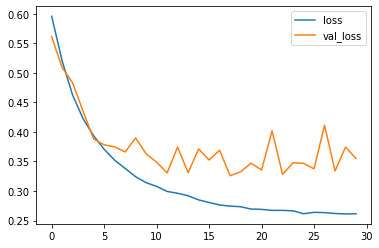

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.9545053839683533


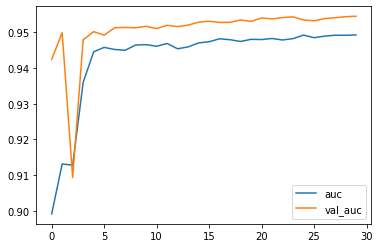

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.8909054398536682


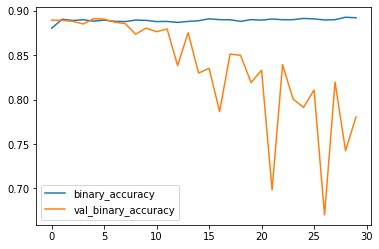

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table3_nn.predict(val_X)
preds1

array([[0.8392706 ],
       [0.24369487],
       [0.37649712],
       ...,
       [0.24369487],
       [0.24369487],
       [0.71344495]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

14571

In [ ]:
len(preds1[preds1 >= 0.5])

7591

In [ ]:
len(val_y)

22162

In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# NN on URL directory attributes (table 3) [model as function]

In [ ]:
y = full_df['phishing']

features_table3 = ['qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
                   'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory',
                   'qty_percent_directory', 'directory_length'] 

X = full_df[features_table3]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,qty_percent_directory,directory_length
5676,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
39002,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1732,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
39668,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
82035,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_3():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[18]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod3 = KerasClassifier(build_fn=phish_nn_3,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_3=cross_val_score(mod3,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.5791 - accuracy: 0.8374 - val_loss: 0.3196 - val_accuracy: 0.8923
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3178 - accuracy: 0.8788 - val_loss: 0.2957 - val_accuracy: 0.8920
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2909 - accuracy: 0.8867 - val_loss: 0.3184 - val_accuracy: 0.8921
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2904 - accuracy: 0.8858 - val_loss: 0.2983 - val_accuracy: 0.8920
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2897 - accuracy: 0.8853 - val_loss: 0.3036 - val_accuracy: 0.8925
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2808 - accuracy: 0.8896 - val_loss: 0.3107 - val_accuracy: 0.8922
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2773 - accuracy: 0.8919 - val_loss: 0.2899 - val_accuracy: 0.8927
Epoch 

In [ ]:
print(round(cv_results_3.mean(), 4))

0.8966


In [ ]:
print(round(cv_results_3.std(), 4))

0.0026


In [ ]:
cv_results_3

array([0.89802593, 0.89379585, 0.89965594, 0.89311296, 0.89835864])

In [ ]:
cv3_preds = cross_val_predict(mod3, X, y, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6360 - accuracy: 0.8271 - val_loss: 0.5616 - val_accuracy: 0.8925
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5312 - accuracy: 0.8903 - val_loss: 0.5318 - val_accuracy: 0.8920
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4822 - accuracy: 0.8899 - val_loss: 0.4744 - val_accuracy: 0.8925
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4411 - accuracy: 0.8901 - val_loss: 0.4334 - val_accuracy: 0.8933
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4122 - accuracy: 0.8892 - val_loss: 0.4081 - val_accuracy: 0.8930
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3808 - accuracy: 0.8919 - val_loss: 0.3862 - val_accuracy: 0.8925
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3606 - accuracy: 0.8941 - val_loss: 0.3732 - val_accuracy: 0.8936
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6219 - accuracy: 0.8393 - val_loss: 0.4847 - val_accuracy: 0.8926
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4092 - accuracy: 0.8857 - val_loss: 0.3276 - val_accuracy: 0.8925
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3149 - accuracy: 0.8799 - val_loss: 0.3131 - val_accuracy: 0.8926
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2993 - accuracy: 0.8774 - val_loss: 0.2884 - val_accuracy: 0.8926
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2851 - accuracy: 0.8839 - val_loss: 0.2998 - val_accuracy: 0.8912
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2901 - accuracy: 0.8814 - val_loss: 0.2886 - val_accuracy: 0.8925
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2836 - accuracy: 0.8842 - val_loss: 0.2842 - val_accuracy: 0.8924
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.5899 - accuracy: 0.8498 - val_loss: 0.3506 - val_accuracy: 0.8924
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8855 - val_loss: 0.3085 - val_accuracy: 0.8925
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2993 - accuracy: 0.8844 - val_loss: 0.3050 - val_accuracy: 0.8928
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2918 - accuracy: 0.8852 - val_loss: 0.2915 - val_accuracy: 0.8924
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2839 - accuracy: 0.8901 - val_loss: 0.2913 - val_accuracy: 0.8913
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2849 - accuracy: 0.8887 - val_loss: 0.2843 - val_accuracy: 0.8925
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2787 - accuracy: 0.8906 - val_loss: 0.2880 - val_accuracy: 0.8917
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.5950 - accuracy: 0.8495 - val_loss: 0.3765 - val_accuracy: 0.8565
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3171 - accuracy: 0.8802 - val_loss: 0.3216 - val_accuracy: 0.8924
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8827 - val_loss: 0.2959 - val_accuracy: 0.8925
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2917 - accuracy: 0.8813 - val_loss: 0.2864 - val_accuracy: 0.8926
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2859 - accuracy: 0.8878 - val_loss: 0.2961 - val_accuracy: 0.8910
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2842 - accuracy: 0.8875 - val_loss: 0.2940 - val_accuracy: 0.8918
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2811 - accuracy: 0.8879 - val_loss: 0.2726 - val_accuracy: 0.8921
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.8325 - val_loss: 0.3090 - val_accuracy: 0.8925
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.3125 - accuracy: 0.8833 - val_loss: 0.3300 - val_accuracy: 0.8883
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.8851 - val_loss: 0.2884 - val_accuracy: 0.8928
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2820 - accuracy: 0.8903 - val_loss: 0.2969 - val_accuracy: 0.8923
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2881 - accuracy: 0.8872 - val_loss: 0.3059 - val_accuracy: 0.8922
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2823 - accuracy: 0.8887 - val_loss: 0.3153 - val_accuracy: 0.8924
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.2758 - accuracy: 0.8905 - val_loss: 0.2873 - val_accuracy: 0.8938
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min finished


In [ ]:
cm3 = confusion_matrix(y, cv3_preds)
print(cm3)

[[53239  4761]
 [ 4368 26279]]


In [ ]:
'''

dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]
param_grid = dict(dropout_rate=dropout_rate)
grid3 = GridSearchCV(estimator=mod3, param_grid=param_grid, cv=10)
grid_result3 = grid3.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
for params, mean_score, scores in grid_result3.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'''

'\n\ndropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]\nparam_grid = dict(dropout_rate=dropout_rate)\ngrid3 = GridSearchCV(estimator=mod3, param_grid=param_grid, cv=10)\ngrid_result3 = grid3.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))\nfor params, mean_score, scores in grid_result3.grid_scores_:\n    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'

# neural network on dataset attributes based on URL file name (table 4)

### (18 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file',
                   'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
                   'qty_percent_file', 'file_length'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length
5676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(88647, 18)

In [ ]:
tf.keras.backend.clear_session()

#neural net

table4_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[18]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table4_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table4_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table4_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6279 - binary_accuracy: 0.7818 - auc: 0.7406 - val_loss: 0.5078 - val_binary_accuracy: 0.7895 - val_auc: 0.7632
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.4985 - binary_accuracy: 0.8008 - auc: 0.7582 - val_loss: 0.5015 - val_binary_accuracy: 0.8121 - val_auc: 0.7638
Epoch 3/500
266/266 [==============================] - 1s 6ms/step - loss: 0.4890 - binary_accuracy: 0.8059 - auc: 0.7565 - val_loss: 0.4806 - val_binary_accuracy: 0.8131 - val_auc: 0.7640
Epoch 4/500
266/266 [==============================] - 1s 6ms/step - loss: 0.4803 - binary_accuracy: 0.8095 - auc: 0.7613 - val_loss: 0.4852 - val_binary_accuracy: 0.8127 - val_auc: 0.7643
Epoch 5/500
266/266 [==============================] - 1s 5ms/step - loss: 0.4806 - binary_accuracy: 0.8102 - auc: 0.7586 - val_loss: 0.4753 - val_binary_accuracy: 0.8120 - val_auc: 0.7641
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.476857,0.810889,0.761227,0.474175,0.814132,0.766123
std,0.012312,0.002779,0.002623,0.005839,0.002961,0.000776
min,0.472327,0.791852,0.744801,0.470258,0.789532,0.763244
25%,0.473347,0.810632,0.760276,0.471381,0.814424,0.766020
50%,0.474394,0.811803,0.761579,0.472325,0.814800,0.766362
75%,0.476338,0.812136,0.762697,0.474716,0.815038,0.766623
max,0.579457,0.812759,0.766824,0.507849,0.815351,0.767213


In [ ]:
train_acc = table4_nn.evaluate(train_X, train_y)
test_acc = table4_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.4730 - binary_accuracy: 0.8123 - auc: 0.7616


In [ ]:
dict(zip(table4_nn.metrics_names, test_acc))

{'auc': 0.7615656852722168,
 'binary_accuracy': 0.8123364448547363,
 'loss': 0.47299692034721375}

Minimum validation loss (binary_crossentropy): 0.47025832533836365


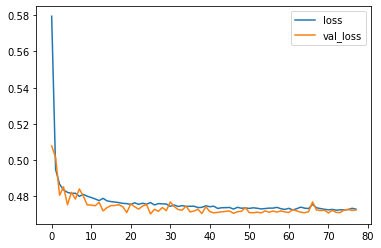

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.7672128677368164


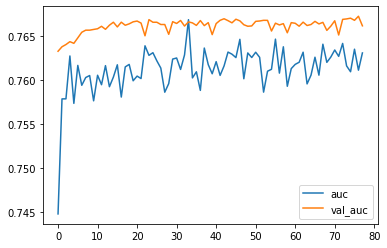

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.8153514266014099


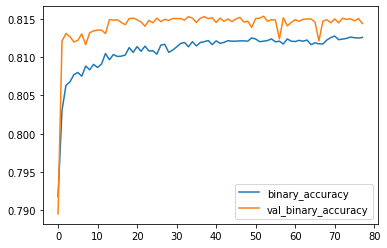

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table4_nn.predict(val_X)
preds1

array([[0.87461555],
       [0.19973338],
       [0.6438374 ],
       ...,
       [0.19973338],
       [0.19973338],
       [0.8664142 ]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

17200

In [ ]:
len(preds1[preds1 >= 0.5])

4962

In [ ]:
len(val_y)

22162

In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# NN on URL file name attributes (table 4) [model as function]

In [ ]:
y = full_df['phishing']

features_table4 = ['qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file',
                   'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
                   'qty_percent_file', 'file_length'] 

X = full_df[features_table4]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length
5676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_4():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[18]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod4 = KerasClassifier(build_fn=phish_nn_4,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_4=cross_val_score(mod4,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6491 - accuracy: 0.7736 - val_loss: 0.5922 - val_accuracy: 0.8124
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5764 - accuracy: 0.8066 - val_loss: 0.5652 - val_accuracy: 0.8119
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5400 - accuracy: 0.8076 - val_loss: 0.5373 - val_accuracy: 0.8130
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5159 - accuracy: 0.8081 - val_loss: 0.5279 - val_accuracy: 0.8116
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5021 - accuracy: 0.8082 - val_loss: 0.5150 - val_accuracy: 0.8121
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4983 - accuracy: 0.8053 - val_loss: 0.5149 - val_accuracy: 0.8103
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4897 - accuracy: 0.8079 - val_loss: 0.5003 - val_accuracy: 0.8130
Epoch 

In [ ]:
print(round(cv_results_4.mean(), 4))

0.8114


In [ ]:
print(round(cv_results_4.std(), 4))

0.0032


In [ ]:
cv_results_4

array([0.81229556, 0.81443882, 0.80574203, 0.81064922, 0.81408989])

In [ ]:
cv4_preds = cross_val_predict(mod4, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6165 - accuracy: 0.7695 - val_loss: 0.4912 - val_accuracy: 0.8125
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4901 - accuracy: 0.8075 - val_loss: 0.4988 - val_accuracy: 0.8122
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4903 - accuracy: 0.8046 - val_loss: 0.4907 - val_accuracy: 0.8130
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4805 - accuracy: 0.8101 - val_loss: 0.4792 - val_accuracy: 0.8130
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4812 - accuracy: 0.8093 - val_loss: 0.4763 - val_accuracy: 0.8131
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4845 - accuracy: 0.8072 - val_loss: 0.4768 - val_accuracy: 0.8137
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4872 - accuracy: 0.8045 - val_loss: 0.4806 - val_accuracy: 0.8136
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6424 - accuracy: 0.7853 - val_loss: 0.5554 - val_accuracy: 0.8130
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5294 - accuracy: 0.8012 - val_loss: 0.5321 - val_accuracy: 0.7674
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4939 - accuracy: 0.8031 - val_loss: 0.5434 - val_accuracy: 0.7437
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4894 - accuracy: 0.8061 - val_loss: 0.5076 - val_accuracy: 0.8088
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4849 - accuracy: 0.8064 - val_loss: 0.4894 - val_accuracy: 0.8140
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4844 - accuracy: 0.8078 - val_loss: 0.4899 - val_accuracy: 0.8130
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4824 - accuracy: 0.8095 - val_loss: 0.4835 - val_accuracy: 0.8132
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.5903 - accuracy: 0.7756 - val_loss: 0.4973 - val_accuracy: 0.8134
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.8057 - val_loss: 0.4942 - val_accuracy: 0.8130
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4861 - accuracy: 0.8081 - val_loss: 0.4956 - val_accuracy: 0.8129
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4857 - accuracy: 0.8084 - val_loss: 0.4854 - val_accuracy: 0.8135
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4831 - accuracy: 0.8087 - val_loss: 0.4784 - val_accuracy: 0.8136
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4812 - accuracy: 0.8102 - val_loss: 0.4773 - val_accuracy: 0.8138
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4821 - accuracy: 0.8089 - val_loss: 0.4781 - val_accuracy: 0.8145
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6346 - accuracy: 0.7837 - val_loss: 0.5182 - val_accuracy: 0.8131
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5009 - accuracy: 0.8028 - val_loss: 0.5105 - val_accuracy: 0.8120
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4861 - accuracy: 0.8075 - val_loss: 0.4819 - val_accuracy: 0.8129
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4883 - accuracy: 0.8058 - val_loss: 0.4905 - val_accuracy: 0.8127
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4865 - accuracy: 0.8048 - val_loss: 0.4974 - val_accuracy: 0.8135
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4847 - accuracy: 0.8069 - val_loss: 0.4795 - val_accuracy: 0.8141
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4834 - accuracy: 0.8064 - val_loss: 0.4909 - val_accuracy: 0.8143
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6161 - accuracy: 0.7822 - val_loss: 0.5024 - val_accuracy: 0.8133
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4951 - accuracy: 0.8029 - val_loss: 0.4853 - val_accuracy: 0.8125
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4894 - accuracy: 0.8056 - val_loss: 0.5060 - val_accuracy: 0.8120
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4816 - accuracy: 0.8108 - val_loss: 0.4882 - val_accuracy: 0.8127
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4843 - accuracy: 0.8070 - val_loss: 0.4980 - val_accuracy: 0.8133
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4877 - accuracy: 0.8050 - val_loss: 0.4814 - val_accuracy: 0.8144
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4806 - accuracy: 0.8096 - val_loss: 0.4798 - val_accuracy: 0.8138
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm4 = confusion_matrix(y, cv4_preds)
print(cm4)

[[54478  3522]
 [13204 17443]]


In [ ]:
'''
dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4]
param_grid = dict(dropout_rate=dropout_rate)
grid4 = GridSearchCV(estimator=mod4, param_grid=param_grid, cv=10)
grid_result4 = grid4.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
for params, mean_score, scores in grid_result4.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))'''

# neural network on dataset attributes based on URL parameters (table 5)

### (20 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_equal_params', 'qty_at_params', 'qty_and_params',
                   'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params',
                   'qty_percent_params', 'params_length', 'tld_present_params', 'qty_params'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params
5676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(88647, 20)

In [ ]:
tf.keras.backend.clear_session()

#neural net

table5_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[20]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table5_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table5_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table5_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6327 - binary_accuracy: 0.7040 - auc: 0.5997 - val_loss: 0.5874 - val_binary_accuracy: 0.7177 - val_auc: 0.6026
Epoch 2/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5889 - binary_accuracy: 0.7154 - auc: 0.6075 - val_loss: 0.5767 - val_binary_accuracy: 0.7223 - val_auc: 0.6029
Epoch 3/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5799 - binary_accuracy: 0.7191 - auc: 0.5991 - val_loss: 0.5778 - val_binary_accuracy: 0.7234 - val_auc: 0.6030
Epoch 4/500
266/266 [==============================] - 2s 6ms/step - loss: 0.5777 - binary_accuracy: 0.7193 - auc: 0.6019 - val_loss: 0.5770 - val_binary_accuracy: 0.7251 - val_auc: 0.6031
Epoch 5/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5760 - binary_accuracy: 0.7217 - auc: 0.6049 - val_loss: 0.5767 - val_binary_accuracy: 0.7250 - val_auc: 0.6030
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.575082,0.721122,0.604629,0.573038,0.725475,0.603759
std,0.006245,0.001653,0.002145,0.003972,0.001842,0.000534
min,0.571837,0.713101,0.598813,0.568824,0.717688,0.601519
25%,0.572771,0.721363,0.603742,0.570575,0.725910,0.603837
50%,0.573426,0.721642,0.604710,0.571990,0.726085,0.603943
75%,0.574563,0.721803,0.606124,0.574230,0.726211,0.604031
max,0.609140,0.722018,0.608472,0.587438,0.726311,0.604143


In [ ]:
train_acc = table5_nn.evaluate(train_X, train_y)
test_acc = table5_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.5749 - binary_accuracy: 0.7248 - auc: 0.6062


In [ ]:
dict(zip(table5_nn.metrics_names, test_acc))

{'auc': 0.6062233448028564,
 'binary_accuracy': 0.7247992157936096,
 'loss': 0.5748729109764099}

Minimum validation loss (binary_crossentropy): 0.5688237547874451


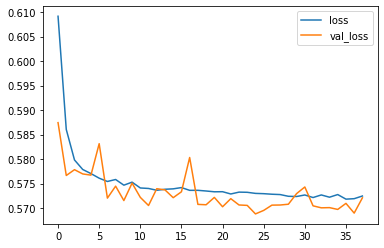

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.6041432023048401


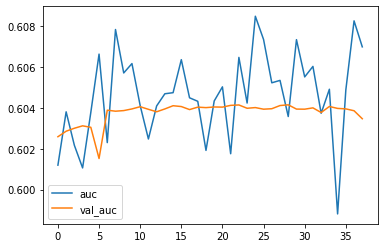

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.7263110280036926


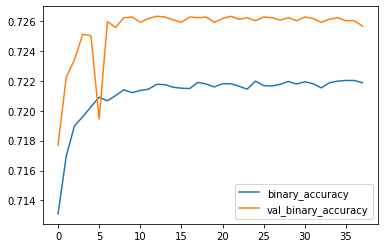

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table5_nn.predict(val_X)
preds1

array([[0.30349493],
       [0.30349493],
       [0.30349493],
       ...,
       [0.30349493],
       [0.30349493],
       [0.30349493]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

20332

In [ ]:
len(preds1[preds1 >= 0.5])

1830

In [ ]:
len(val_y)

22162

# NN on URL parameter attributes (table 5) [model as function]

In [ ]:
y = full_df['phishing']

features_table5 = ['qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_equal_params', 'qty_at_params', 'qty_and_params',
                   'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params',
                   'qty_percent_params', 'params_length', 'tld_present_params', 'qty_params'] 

X = full_df[features_table5]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params
5676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_5():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[20]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod5 = KerasClassifier(build_fn=phish_nn_5,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_5=cross_val_score(mod5,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6305 - accuracy: 0.7027 - val_loss: 0.5767 - val_accuracy: 0.7232
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5802 - accuracy: 0.7207 - val_loss: 0.5755 - val_accuracy: 0.7260
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5747 - accuracy: 0.7230 - val_loss: 0.5795 - val_accuracy: 0.7234
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5773 - accuracy: 0.7199 - val_loss: 0.5733 - val_accuracy: 0.7255
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5765 - accuracy: 0.7197 - val_loss: 0.5732 - val_accuracy: 0.7234
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5729 - accuracy: 0.7239 - val_loss: 0.5747 - val_accuracy: 0.7259
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5755 - accuracy: 0.7210 - val_loss: 0.5779 - val_accuracy: 0.7261
Epoch 

In [ ]:
print(round(cv_results_5.mean(), 4))

0.7236


In [ ]:
print(round(cv_results_5.std(), 4))

0.0021


In [ ]:
cv_results_5

array([0.72069937, 0.72633952, 0.72559083, 0.72305262, 0.72237575])

In [ ]:
cv5_preds = cross_val_predict(mod5, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6342 - accuracy: 0.7043 - val_loss: 0.5783 - val_accuracy: 0.7243
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5821 - accuracy: 0.7204 - val_loss: 0.5724 - val_accuracy: 0.7259
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5793 - accuracy: 0.7196 - val_loss: 0.5727 - val_accuracy: 0.7259
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5763 - accuracy: 0.7224 - val_loss: 0.5735 - val_accuracy: 0.7261
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5727 - accuracy: 0.7226 - val_loss: 0.5835 - val_accuracy: 0.7237
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5793 - accuracy: 0.7176 - val_loss: 0.5752 - val_accuracy: 0.7246
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5751 - accuracy: 0.7205 - val_loss: 0.5769 - val_accuracy: 0.7258
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6484 - accuracy: 0.6984 - val_loss: 0.5801 - val_accuracy: 0.7243
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5865 - accuracy: 0.7182 - val_loss: 0.5723 - val_accuracy: 0.7259
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5790 - accuracy: 0.7217 - val_loss: 0.5737 - val_accuracy: 0.7262
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5733 - accuracy: 0.7247 - val_loss: 0.5776 - val_accuracy: 0.7240
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5756 - accuracy: 0.7227 - val_loss: 0.5720 - val_accuracy: 0.7263
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5789 - accuracy: 0.7183 - val_loss: 0.5721 - val_accuracy: 0.7259
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5742 - accuracy: 0.7232 - val_loss: 0.5718 - val_accuracy: 0.7259
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6394 - accuracy: 0.7068 - val_loss: 0.5767 - val_accuracy: 0.7243
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5776 - accuracy: 0.7231 - val_loss: 0.5745 - val_accuracy: 0.7248
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5793 - accuracy: 0.7195 - val_loss: 0.5726 - val_accuracy: 0.7265
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5753 - accuracy: 0.7231 - val_loss: 0.5719 - val_accuracy: 0.7259
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5755 - accuracy: 0.7222 - val_loss: 0.5784 - val_accuracy: 0.7262
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5788 - accuracy: 0.7194 - val_loss: 0.5708 - val_accuracy: 0.7259
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5752 - accuracy: 0.7211 - val_loss: 0.5789 - val_accuracy: 0.7257
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6307 - accuracy: 0.7103 - val_loss: 0.5788 - val_accuracy: 0.7243
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5857 - accuracy: 0.7169 - val_loss: 0.5748 - val_accuracy: 0.7246
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5779 - accuracy: 0.7217 - val_loss: 0.5714 - val_accuracy: 0.7259
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5775 - accuracy: 0.7201 - val_loss: 0.5721 - val_accuracy: 0.7252
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5733 - accuracy: 0.7235 - val_loss: 0.5741 - val_accuracy: 0.7263
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5766 - accuracy: 0.7190 - val_loss: 0.5715 - val_accuracy: 0.7261
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5748 - accuracy: 0.7224 - val_loss: 0.5813 - val_accuracy: 0.7234
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6440 - accuracy: 0.7015 - val_loss: 0.5799 - val_accuracy: 0.7242
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5808 - accuracy: 0.7207 - val_loss: 0.5719 - val_accuracy: 0.7259
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5741 - accuracy: 0.7244 - val_loss: 0.5733 - val_accuracy: 0.7257
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5741 - accuracy: 0.7230 - val_loss: 0.5726 - val_accuracy: 0.7266
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5724 - accuracy: 0.7264 - val_loss: 0.5714 - val_accuracy: 0.7258
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5717 - accuracy: 0.7249 - val_loss: 0.5739 - val_accuracy: 0.7260
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5735 - accuracy: 0.7225 - val_loss: 0.5703 - val_accuracy: 0.7259
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm5 = confusion_matrix(y, cv5_preds)
print(cm5)

[[57445   555]
 [23948  6699]]


# neural network on dataset attributes based on URL resolving data and external metrics (table 6)

### (14 features)

In [ ]:
y = full_df['phishing']

features_table1 = ['time_response', 'domain_spf', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate',
                   'qty_redirects', 'url_google_index', 'domain_google_index', 'url_shortened'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,8.696835,0,262254,155,209,1,6,2,3011,1,0,0,0,0
39002,0.244978,0,2818,0,2625,4,4,2,247,1,1,0,0,0
1732,0.430590,0,15169,5858,350,1,2,1,14399,0,0,0,0,0
39668,0.617731,0,14061,4285,97,1,2,4,7199,0,1,0,0,0
82035,0.149499,0,29671,6669,269,1,4,4,21598,0,0,0,0,0


In [ ]:
X.shape

(88647, 14)

In [ ]:
tf.keras.backend.clear_session()

#neural net

table6_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[14]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

table6_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table6_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history = table6_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 32.2590 - binary_accuracy: 0.5457 - auc: 0.4992 - val_loss: 0.7034 - val_binary_accuracy: 0.6568 - val_auc: 0.5037
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 1.7595 - binary_accuracy: 0.5802 - auc: 0.4929 - val_loss: 0.6575 - val_binary_accuracy: 0.6576 - val_auc: 0.3860
Epoch 3/500
266/266 [==============================] - 1s 5ms/step - loss: 1.0169 - binary_accuracy: 0.6103 - auc: 0.4973 - val_loss: 0.6427 - val_binary_accuracy: 0.6589 - val_auc: 0.4889
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.8251 - binary_accuracy: 0.6267 - auc: 0.5012 - val_loss: 0.6415 - val_binary_accuracy: 0.6592 - val_auc: 0.5237
Epoch 5/500
266/266 [==============================] - 1s 5ms/step - loss: 0.7500 - binary_accuracy: 0.6300 - auc: 0.5028 - val_loss: 0.6414 - val_binary_accuracy: 0.6592 - val_auc: 0.5211
Epoch 6/500
266/266 [==============================] -

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,1.090051,0.641658,0.526685,0.633891,0.659035,0.542427
std,2.109026,0.020677,0.055095,0.024581,0.000516,0.096086
min,0.593613,0.557532,0.495854,0.581833,0.656823,0.386016
25%,0.648457,0.645330,0.499809,0.641391,0.659180,0.500000
50%,0.654094,0.649627,0.502311,0.641615,0.659180,0.500000
75%,0.673525,0.650938,0.506521,0.641672,0.659180,0.523662
max,12.020675,0.651647,0.670968,0.703430,0.659180,0.734637


In [ ]:
train_acc = table6_nn.evaluate(train_X, train_y)
test_acc = table6_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.6444 - binary_accuracy: 0.6551 - auc: 0.5216


In [ ]:
dict(zip(table6_nn.metrics_names, test_acc))

{'auc': 0.5216185450553894,
 'binary_accuracy': 0.6551303863525391,
 'loss': 0.6443995833396912}

Minimum validation loss (binary_crossentropy): 0.5818330645561218


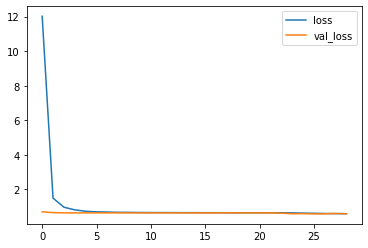

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.7346371412277222


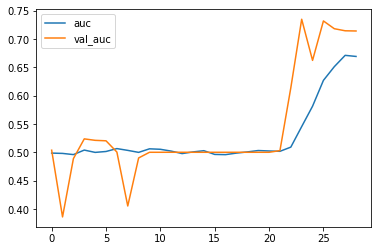

In [ ]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.6591798067092896


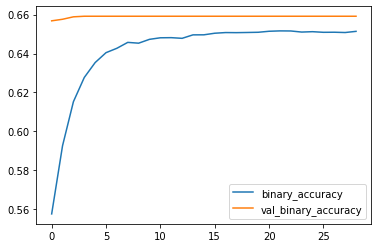

In [ ]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [ ]:
preds1 = table6_nn.predict(val_X)
preds1

array([[0.32830507],
       [0.32830507],
       [0.33570668],
       ...,
       [0.33615583],
       [0.32830507],
       [0.37132597]], dtype=float32)

In [ ]:
len(preds1[preds1 < 0.5])

22162

In [ ]:
len(preds1[preds1 >= 0.5])

0

In [ ]:
len(val_y)

22162

In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# NN on URL resolving data and external metric attributes (table 6) [model as function]

In [ ]:
y = full_df['phishing']

features_table6 = ['time_response', 'domain_spf', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate',
                   'qty_redirects', 'url_google_index', 'domain_google_index', 'url_shortened'] 

X = full_df[features_table6]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,0.000033,0.0,0.999934,0.000591,0.000797,0.000004,0.000023,0.000008,0.011480,0.000004,0.000000,0.0,0.0,0.0
39002,0.000063,0.0,0.730219,0.000000,0.680207,0.001037,0.001037,0.000518,0.064004,0.000259,0.000259,0.0,0.0,0.0
1732,0.000020,0.0,0.698307,0.269674,0.016112,0.000046,0.000092,0.000046,0.662860,0.000000,0.000000,0.0,0.0,0.0
39668,0.000038,0.0,0.859060,0.261793,0.005926,0.000061,0.000122,0.000244,0.439824,0.000000,0.000061,0.0,0.0,0.0
82035,0.000004,0.0,0.795441,0.178787,0.007212,0.000027,0.000107,0.000107,0.579014,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_6():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[14]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod6 = KerasClassifier(build_fn=phish_nn_6,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_6=cross_val_score(mod6,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6269 - accuracy: 0.6479 - val_loss: 0.5881 - val_accuracy: 0.7189
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5627 - accuracy: 0.7027 - val_loss: 0.5820 - val_accuracy: 0.7188
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5558 - accuracy: 0.7103 - val_loss: 0.5764 - val_accuracy: 0.7216
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5512 - accuracy: 0.7148 - val_loss: 0.5746 - val_accuracy: 0.7199
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5559 - accuracy: 0.7079 - val_loss: 0.5601 - val_accuracy: 0.7199
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5507 - accuracy: 0.7151 - val_loss: 0.5511 - val_accuracy: 0.7194
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5491 - accuracy: 0.7134 - val_loss: 0.5504 - val_accuracy: 0.7227
Epoch 

In [ ]:
print(round(cv_results_6.mean(), 4))

0.7197


In [ ]:
print(round(cv_results_6.std(), 4))

0.0024


In [ ]:
cv_results_6

array([0.72047377, 0.72295547, 0.71995038, 0.71944273, 0.71543801])

In [ ]:
cv6_preds = cross_val_predict(mod6, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6334 - accuracy: 0.6398 - val_loss: 0.5792 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5663 - accuracy: 0.6852 - val_loss: 0.5644 - val_accuracy: 0.7183
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5629 - accuracy: 0.7094 - val_loss: 0.5745 - val_accuracy: 0.7199
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5558 - accuracy: 0.7166 - val_loss: 0.5650 - val_accuracy: 0.7204
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5539 - accuracy: 0.7137 - val_loss: 0.5665 - val_accuracy: 0.7098
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5491 - accuracy: 0.7156 - val_loss: 0.5466 - val_accuracy: 0.7211
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5529 - accuracy: 0.7109 - val_loss: 0.5495 - val_accuracy: 0.7198
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6252 - accuracy: 0.6487 - val_loss: 0.5729 - val_accuracy: 0.7151
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5719 - accuracy: 0.6921 - val_loss: 0.5897 - val_accuracy: 0.7197
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5602 - accuracy: 0.7119 - val_loss: 0.5723 - val_accuracy: 0.7163
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5534 - accuracy: 0.7102 - val_loss: 0.5866 - val_accuracy: 0.7202
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5544 - accuracy: 0.7100 - val_loss: 0.5558 - val_accuracy: 0.7216
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5543 - accuracy: 0.7108 - val_loss: 0.5528 - val_accuracy: 0.7199
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5514 - accuracy: 0.7129 - val_loss: 0.5580 - val_accuracy: 0.7153
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6288 - accuracy: 0.6471 - val_loss: 0.5932 - val_accuracy: 0.7158
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5652 - accuracy: 0.7014 - val_loss: 0.6032 - val_accuracy: 0.7188
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5588 - accuracy: 0.7089 - val_loss: 0.5770 - val_accuracy: 0.7208
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5544 - accuracy: 0.7128 - val_loss: 0.5611 - val_accuracy: 0.7166
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5511 - accuracy: 0.7138 - val_loss: 0.5602 - val_accuracy: 0.7207
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5513 - accuracy: 0.7100 - val_loss: 0.5457 - val_accuracy: 0.7180
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5511 - accuracy: 0.7152 - val_loss: 0.5603 - val_accuracy: 0.7193
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6226 - accuracy: 0.6499 - val_loss: 0.5794 - val_accuracy: 0.7164
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5631 - accuracy: 0.6997 - val_loss: 0.6032 - val_accuracy: 0.7099
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5612 - accuracy: 0.7085 - val_loss: 0.5820 - val_accuracy: 0.7189
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5571 - accuracy: 0.7111 - val_loss: 0.5830 - val_accuracy: 0.7194
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5531 - accuracy: 0.7163 - val_loss: 0.5770 - val_accuracy: 0.7203
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5544 - accuracy: 0.7124 - val_loss: 0.5533 - val_accuracy: 0.7118
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5494 - accuracy: 0.7129 - val_loss: 0.5606 - val_accuracy: 0.7220
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6250 - accuracy: 0.6536 - val_loss: 0.5754 - val_accuracy: 0.7165
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5688 - accuracy: 0.7011 - val_loss: 0.5972 - val_accuracy: 0.7194
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5600 - accuracy: 0.7106 - val_loss: 0.5707 - val_accuracy: 0.7200
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5550 - accuracy: 0.7112 - val_loss: 0.5804 - val_accuracy: 0.7182
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5505 - accuracy: 0.7163 - val_loss: 0.5668 - val_accuracy: 0.7222
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5496 - accuracy: 0.7154 - val_loss: 0.5700 - val_accuracy: 0.7234
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5518 - accuracy: 0.7123 - val_loss: 0.5562 - val_accuracy: 0.7226
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm6 = confusion_matrix(y, cv6_preds)
print(cm6)

[[41600 16400]
 [ 8383 22264]]


# neural network on top 10 most important features per recursive feature elimination package 

## (big thanks to Jack for getting these for us)

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'directory_length', 'qty_hyphen_file', 'file_length', 'asn_ip', 'time_domain_activation']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,directory_length,qty_hyphen_file,file_length,asn_ip,time_domain_activation
5676,0.000004,0.000042,0.0,0.0,0.000004,0.000004,0.0,0.0,1.000000,0.000591
39002,0.000000,0.004613,0.0,0.0,0.000000,0.000000,0.0,0.0,0.999989,0.000000
1732,0.000000,0.000984,0.0,0.0,0.000000,0.000000,0.0,0.0,0.932855,0.360252
39668,0.000000,0.001769,0.0,0.0,0.000000,0.000000,0.0,0.0,0.956567,0.291508
82035,0.000000,0.000921,0.0,0.0,0.000000,0.000000,0.0,0.0,0.975658,0.219294


In [ ]:
tf.keras.backend.clear_session()

#neural net

top_10_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[10]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

top_10_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_10_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history1 = top_10_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6274 - binary_accuracy: 0.6444 - auc: 0.6111 - val_loss: 0.5834 - val_binary_accuracy: 0.7110 - val_auc: 0.7485
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5638 - binary_accuracy: 0.6969 - auc: 0.7355 - val_loss: 0.5623 - val_binary_accuracy: 0.7130 - val_auc: 0.7572
Epoch 3/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5506 - binary_accuracy: 0.7082 - auc: 0.7470 - val_loss: 0.5650 - val_binary_accuracy: 0.7164 - val_auc: 0.7717
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5285 - binary_accuracy: 0.7223 - auc: 0.7655 - val_loss: 0.5552 - val_binary_accuracy: 0.6950 - val_auc: 0.7802
Epoch 5/500
266/266 [==============================] - 1s 5ms/step - loss: 0.4760 - binary_accuracy: 0.7565 - auc: 0.8120 - val_loss: 0.4350 - val_binary_accuracy: 0.8071 - val_auc: 0.8747
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.329842,0.855387,0.915682,0.351159,0.868943,0.934057
std,0.075952,0.051974,0.055611,0.081758,0.054248,0.051370
min,0.274853,0.651174,0.694853,0.250324,0.694976,0.748510
25%,0.286742,0.858893,0.922186,0.295454,0.878823,0.939191
50%,0.299963,0.876598,0.936873,0.314257,0.891858,0.954127
75%,0.331790,0.882722,0.942204,0.388238,0.899955,0.958403
max,0.595459,0.887943,0.947103,0.583396,0.912012,0.962620


In [ ]:
train_acc = top_10_nn.evaluate(train_X, train_y)
test_acc = top_10_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.3457 - binary_accuracy: 0.9107 - auc: 0.9543


In [ ]:
dict(zip(top_10_nn.metrics_names, test_acc))

{'auc': 0.9543376564979553,
 'binary_accuracy': 0.9106578826904297,
 'loss': 0.3456972539424896}

Minimum validation loss (binary_crossentropy): 0.2503238916397095


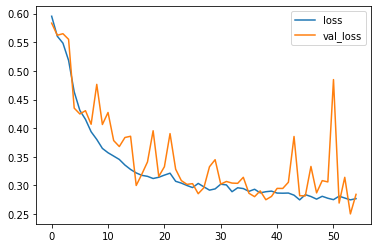

In [ ]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9626195430755615


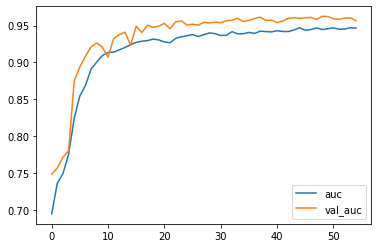

In [ ]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9120124578475952


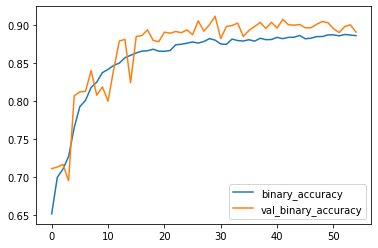

In [ ]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [ ]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.024069011211395264

In [ ]:
preds1 = top_10_nn.predict(val_X)
preds1

array([[0.8667137 ],
       [0.09227356],
       [0.60327375],
       ...,
       [0.47996977],
       [0.15259656],
       [0.8667137 ]], dtype=float32)

In [ ]:
len(preds1[preds1 <= 0.5])

13617

In [ ]:
len(preds1[preds1 > 0.5])

8545

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.866714
1,0.092274
2,0.603274
3,0.216972
4,0.806232


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_slash_url,length_url,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,directory_length,qty_hyphen_file,file_length,asn_ip,time_domain_activation
0,0.866714,1,62575,0.002483,0.025323,0.000000,0.000000,0.002483,0.016882,0.000000,0.004965,0.000000,0.999518
1,0.092274,0,38126,0.000000,0.001221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.949305,0.314353
2,0.603274,0,1617,0.000069,0.002349,0.000069,0.000000,0.000069,0.001036,0.000069,0.000967,0.921329,0.388775
3,0.216972,0,8228,0.000000,0.000298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992151,0.125046
4,0.806232,1,55594,0.060606,0.848485,0.000000,0.030303,0.060606,0.424242,0.000000,0.303030,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.048747,0,65294,0.000000,0.001558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720224,0.693739
22158,0.067605,0,10038,0.000000,0.001086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.904747,0.425947
22159,0.479970,0,43642,0.000000,0.001711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000
22160,0.152597,0,73632,0.000000,0.000730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980816,0.194933


In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# neural network on top 10 most important features per recursive feature elimination package [model as feature]

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'directory_length', 'qty_hyphen_file', 'file_length', 'asn_ip', 'time_domain_activation']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,directory_length,qty_hyphen_file,file_length,asn_ip,time_domain_activation
5676,0.000004,0.000042,0.0,0.0,0.000004,0.000004,0.0,0.0,1.000000,0.000591
39002,0.000000,0.004613,0.0,0.0,0.000000,0.000000,0.0,0.0,0.999989,0.000000
1732,0.000000,0.000984,0.0,0.0,0.000000,0.000000,0.0,0.0,0.932855,0.360252
39668,0.000000,0.001769,0.0,0.0,0.000000,0.000000,0.0,0.0,0.956567,0.291508
82035,0.000000,0.000921,0.0,0.0,0.000000,0.000000,0.0,0.0,0.975658,0.219294


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_top10():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[10]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod_top10 = KerasClassifier(build_fn=phish_nn_top10,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_top10 = cross_val_score(mod_top10,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6247 - accuracy: 0.6463 - val_loss: 0.5855 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5634 - accuracy: 0.6939 - val_loss: 0.5744 - val_accuracy: 0.7128
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5475 - accuracy: 0.7073 - val_loss: 0.5806 - val_accuracy: 0.7096
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5447 - accuracy: 0.7114 - val_loss: 0.5398 - val_accuracy: 0.7284
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5104 - accuracy: 0.7307 - val_loss: 0.4619 - val_accuracy: 0.7722
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4723 - accuracy: 0.7588 - val_loss: 0.4395 - val_accuracy: 0.8025
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4321 - accuracy: 0.7926 - val_loss: 0.4184 - val_accuracy: 0.8101
Epoch 

In [ ]:
print(round(cv_results_top10.mean(), 4))

0.894


In [ ]:
print(round(cv_results_top10.std(), 4))

0.0098


In [ ]:
cv_results_top10

array([0.91302878, 0.88877606, 0.88544196, 0.89153367, 0.89136446])

In [ ]:
cv_top10_preds = cross_val_predict(mod_top10, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6264 - accuracy: 0.6454 - val_loss: 0.5845 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5656 - accuracy: 0.6848 - val_loss: 0.5868 - val_accuracy: 0.7130
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5523 - accuracy: 0.7061 - val_loss: 0.5627 - val_accuracy: 0.7136
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5446 - accuracy: 0.7110 - val_loss: 0.5419 - val_accuracy: 0.7212
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5258 - accuracy: 0.7204 - val_loss: 0.4660 - val_accuracy: 0.7765
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4675 - accuracy: 0.7644 - val_loss: 0.4277 - val_accuracy: 0.7974
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4350 - accuracy: 0.7891 - val_loss: 0.4461 - val_accuracy: 0.7745
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6271 - accuracy: 0.6402 - val_loss: 0.5748 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5623 - accuracy: 0.6970 - val_loss: 0.5726 - val_accuracy: 0.7144
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5508 - accuracy: 0.7093 - val_loss: 0.5720 - val_accuracy: 0.7199
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5292 - accuracy: 0.7224 - val_loss: 0.4729 - val_accuracy: 0.7648
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4647 - accuracy: 0.7645 - val_loss: 0.5198 - val_accuracy: 0.7746
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4314 - accuracy: 0.7921 - val_loss: 0.4899 - val_accuracy: 0.7816
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4090 - accuracy: 0.8103 - val_loss: 0.4609 - val_accuracy: 0.8059
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6352 - accuracy: 0.6440 - val_loss: 0.5750 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5655 - accuracy: 0.6776 - val_loss: 0.5682 - val_accuracy: 0.7090
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5522 - accuracy: 0.7042 - val_loss: 0.5858 - val_accuracy: 0.7120
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5390 - accuracy: 0.7099 - val_loss: 0.4914 - val_accuracy: 0.7696
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4789 - accuracy: 0.7535 - val_loss: 0.4725 - val_accuracy: 0.7643
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4377 - accuracy: 0.7862 - val_loss: 0.4406 - val_accuracy: 0.8046
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4126 - accuracy: 0.8056 - val_loss: 0.4638 - val_accuracy: 0.7968
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6296 - accuracy: 0.6428 - val_loss: 0.5738 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5647 - accuracy: 0.6691 - val_loss: 0.5712 - val_accuracy: 0.7105
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5561 - accuracy: 0.7047 - val_loss: 0.5710 - val_accuracy: 0.7150
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5490 - accuracy: 0.7058 - val_loss: 0.5450 - val_accuracy: 0.7234
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5209 - accuracy: 0.7291 - val_loss: 0.4905 - val_accuracy: 0.7428
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4738 - accuracy: 0.7601 - val_loss: 0.4858 - val_accuracy: 0.7740
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4371 - accuracy: 0.7892 - val_loss: 0.4101 - val_accuracy: 0.8129
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6280 - accuracy: 0.6442 - val_loss: 0.5759 - val_accuracy: 0.6592
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5593 - accuracy: 0.6971 - val_loss: 0.5853 - val_accuracy: 0.7134
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5556 - accuracy: 0.7046 - val_loss: 0.5967 - val_accuracy: 0.7043
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5448 - accuracy: 0.7090 - val_loss: 0.5859 - val_accuracy: 0.7119
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5270 - accuracy: 0.7216 - val_loss: 0.5380 - val_accuracy: 0.7638
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4685 - accuracy: 0.7678 - val_loss: 0.4470 - val_accuracy: 0.8127
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4260 - accuracy: 0.7978 - val_loss: 0.4063 - val_accuracy: 0.8109
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm_top10 = confusion_matrix(y, cv_top10_preds)
print(cm_top10)

[[50015  7985]
 [ 2098 28549]]


# neural network on top 25 most important features per recursive feature elimination package

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_comma_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory', 'directory_length',
       'qty_dot_file', 'qty_hyphen_file', 'qty_at_file',
       'qty_exclamation_file', 'qty_space_file', 'qty_dollar_file',
       'file_length', 'time_response', 'asn_ip', 'time_domain_activation',
       'time_domain_expiration', 'ttl_hostname']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_dot_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_comma_directory,qty_asterisk_directory,qty_hashtag_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_at_file,qty_exclamation_file,qty_space_file,qty_dollar_file,file_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,ttl_hostname
5676,0.000004,0.000042,0.000004,0.000038,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.999934,0.000591,0.000797,0.011480
39002,0.000000,0.003369,0.000777,0.003369,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.730211,0.000000,0.680200,0.064004
1732,0.000000,0.000737,0.000092,0.000737,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.698307,0.269674,0.016112,0.662860
39668,0.000000,0.001588,0.000122,0.001588,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.859058,0.261792,0.005926,0.439823
82035,0.000000,0.000751,0.000054,0.000751,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.795440,0.178787,0.007212,0.579014


In [ ]:
tf.keras.backend.clear_session()

#neural net

top_25_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[25]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

top_25_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_25_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history1 = top_25_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6288 - binary_accuracy: 0.6534 - auc: 0.6046 - val_loss: 0.5887 - val_binary_accuracy: 0.7220 - val_auc: 0.7622
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5574 - binary_accuracy: 0.6959 - auc: 0.7449 - val_loss: 0.5731 - val_binary_accuracy: 0.7196 - val_auc: 0.7675
Epoch 3/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5450 - binary_accuracy: 0.7166 - auc: 0.7545 - val_loss: 0.5680 - val_binary_accuracy: 0.7290 - val_auc: 0.7751
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5325 - binary_accuracy: 0.7263 - auc: 0.7665 - val_loss: 0.5371 - val_binary_accuracy: 0.7465 - val_auc: 0.7997
Epoch 5/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5013 - binary_accuracy: 0.7430 - auc: 0.7959 - val_loss: 0.4994 - val_binary_accuracy: 0.7631 - val_auc: 0.8365
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,0.265472,0.890208,0.946228,0.300549,0.892908,0.958388
std,0.065390,0.039583,0.041134,0.071232,0.038153,0.035725
min,0.227534,0.655235,0.693803,0.215015,0.719593,0.762248
25%,0.235851,0.896517,0.953038,0.252375,0.892309,0.963606
50%,0.243347,0.902469,0.958443,0.285353,0.907701,0.968473
75%,0.258374,0.905219,0.960552,0.322458,0.911912,0.969862
max,0.597459,0.909216,0.963387,0.588668,0.920235,0.972425


In [ ]:
train_acc = top_25_nn.evaluate(train_X, train_y)
test_acc = top_25_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 2ms/step - loss: 0.2246 - binary_accuracy: 0.9197 - auc: 0.9697


In [ ]:
dict(zip(top_25_nn.metrics_names, test_acc))

{'auc': 0.969747006893158,
 'binary_accuracy': 0.9196823239326477,
 'loss': 0.22459127008914948}

Minimum validation loss (binary_crossentropy): 0.21501503884792328


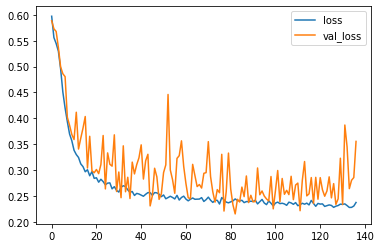

In [ ]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9724253416061401


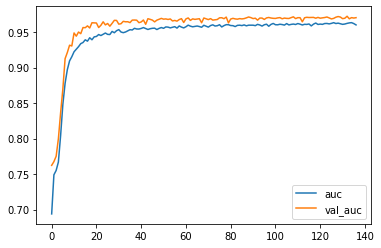

In [ ]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9202346205711365


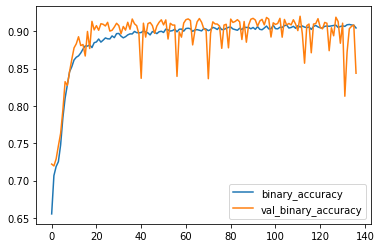

In [ ]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [ ]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.011018693447113037

In [ ]:
preds1 = top_25_nn.predict(val_X)
preds1

array([[0.9255438 ],
       [0.00619072],
       [0.47685236],
       ...,
       [0.1934138 ],
       [0.02817941],
       [0.9255438 ]], dtype=float32)

In [ ]:
len(preds1[preds1 <= 0.5])

13547

In [ ]:
len(preds1[preds1 > 0.5])

8615

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.925544
1,0.006191
2,0.476852
3,0.041735
4,0.631248


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_slash_url,length_url,qty_dot_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_comma_directory,qty_asterisk_directory,qty_hashtag_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_at_file,qty_exclamation_file,qty_space_file,qty_dollar_file,file_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,ttl_hostname
0,0.925544,1,62575,0.000345,0.003517,0.000207,0.001172,0.000069,0.000000,0.000000,0.000345,0.0,0.0,0.0,0.0,0.002345,0.000069,0.000000,0.0,0.0,0.0,0.0,0.000690,0.000007,0.000000,0.138820,0.037377,0.989602
1,0.006191,0,38126,0.000000,0.001012,0.000078,0.001012,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000098,0.786588,0.260471,0.009454,0.559770
2,0.476852,0,1617,0.000069,0.002348,0.000138,0.001312,0.000000,0.000069,0.000000,0.000069,0.0,0.0,0.0,0.0,0.001036,0.000000,0.000069,0.0,0.0,0.0,0.0,0.000967,0.000073,0.921059,0.388661,0.014919,0.018994
3,0.041735,0,8228,0.000000,0.000285,0.000041,0.000285,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000050,0.948421,0.119534,0.021672,0.292813
4,0.631248,1,55594,0.055728,0.780189,0.027864,0.390095,0.027864,0.000000,0.027864,0.055728,0.0,0.0,0.0,0.0,0.390095,0.027864,0.000000,0.0,0.0,0.0,0.0,0.278639,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.000008,0,65294,0.000000,0.001480,0.000261,0.001480,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000089,0.684142,0.658984,0.008618,0.312430
22158,0.001727,0,10038,0.000000,0.001070,0.000134,0.001070,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000010,0.891957,0.419926,0.166352,0.020000
22159,0.193414,0,43642,0.000000,0.001710,0.000149,0.001710,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000043,0.999761,0.000000,0.000000,0.021711
22160,0.028179,0,73632,0.000000,0.000624,0.000048,0.000624,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000007,0.838648,0.166678,0.008666,0.518471


In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# neural network on top 25 most important features per recursive feature elimination package [model as feature]

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_comma_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory', 'directory_length',
       'qty_dot_file', 'qty_hyphen_file', 'qty_at_file',
       'qty_exclamation_file', 'qty_space_file', 'qty_dollar_file',
       'file_length', 'time_response', 'asn_ip', 'time_domain_activation',
       'time_domain_expiration', 'ttl_hostname']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_dot_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_comma_directory,qty_asterisk_directory,qty_hashtag_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_at_file,qty_exclamation_file,qty_space_file,qty_dollar_file,file_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,ttl_hostname
5676,0.000004,0.000042,0.000004,0.000038,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.999934,0.000591,0.000797,0.011480
39002,0.000000,0.003369,0.000777,0.003369,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.730211,0.000000,0.680200,0.064004
1732,0.000000,0.000737,0.000092,0.000737,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.698307,0.269674,0.016112,0.662860
39668,0.000000,0.001588,0.000122,0.001588,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.859058,0.261792,0.005926,0.439823
82035,0.000000,0.000751,0.000054,0.000751,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.795440,0.178787,0.007212,0.579014


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_top25():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[25]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod_top25 = KerasClassifier(build_fn=phish_nn_top25,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_top25 = cross_val_score(mod_top25,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6254 - accuracy: 0.6462 - val_loss: 0.5668 - val_accuracy: 0.7192
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5590 - accuracy: 0.7064 - val_loss: 0.6071 - val_accuracy: 0.7219
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5469 - accuracy: 0.7184 - val_loss: 0.5618 - val_accuracy: 0.7266
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5416 - accuracy: 0.7186 - val_loss: 0.5276 - val_accuracy: 0.7342
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5297 - accuracy: 0.7248 - val_loss: 0.5220 - val_accuracy: 0.7491
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5059 - accuracy: 0.7440 - val_loss: 0.4728 - val_accuracy: 0.7688
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4554 - accuracy: 0.7817 - val_loss: 0.4314 - val_accuracy: 0.8351
Epoch 

In [ ]:
print(round(cv_results_top25.mean(), 4))

0.9011


In [ ]:
print(round(cv_results_top25.std(), 4))

0.0129


In [ ]:
cv_results_top25

array([0.91511559, 0.91596162, 0.90067124, 0.88470864, 0.88922107])

In [ ]:
cv_top25_preds = cross_val_predict(mod_top25, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6290 - accuracy: 0.6461 - val_loss: 0.5721 - val_accuracy: 0.7201
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5616 - accuracy: 0.7018 - val_loss: 0.5727 - val_accuracy: 0.7241
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5504 - accuracy: 0.7146 - val_loss: 0.5727 - val_accuracy: 0.7220
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5460 - accuracy: 0.7161 - val_loss: 0.5572 - val_accuracy: 0.7289
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5396 - accuracy: 0.7199 - val_loss: 0.5429 - val_accuracy: 0.7298
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5250 - accuracy: 0.7274 - val_loss: 0.5336 - val_accuracy: 0.7370
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4985 - accuracy: 0.7514 - val_loss: 0.4696 - val_accuracy: 0.7823
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6222 - accuracy: 0.6540 - val_loss: 0.5529 - val_accuracy: 0.7216
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5582 - accuracy: 0.7067 - val_loss: 0.5718 - val_accuracy: 0.7237
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5437 - accuracy: 0.7208 - val_loss: 0.5397 - val_accuracy: 0.7284
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5387 - accuracy: 0.7230 - val_loss: 0.5392 - val_accuracy: 0.7314
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5245 - accuracy: 0.7301 - val_loss: 0.5027 - val_accuracy: 0.7494
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4922 - accuracy: 0.7547 - val_loss: 0.4720 - val_accuracy: 0.7785
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4502 - accuracy: 0.7847 - val_loss: 0.4108 - val_accuracy: 0.8135
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6300 - accuracy: 0.6453 - val_loss: 0.5533 - val_accuracy: 0.7172
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5617 - accuracy: 0.7005 - val_loss: 0.5865 - val_accuracy: 0.7108
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5484 - accuracy: 0.7162 - val_loss: 0.5638 - val_accuracy: 0.7220
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5387 - accuracy: 0.7208 - val_loss: 0.5561 - val_accuracy: 0.7233
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5263 - accuracy: 0.7283 - val_loss: 0.5051 - val_accuracy: 0.7472
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4931 - accuracy: 0.7494 - val_loss: 0.4439 - val_accuracy: 0.7990
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4461 - accuracy: 0.7884 - val_loss: 0.4365 - val_accuracy: 0.7981
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6301 - accuracy: 0.6481 - val_loss: 0.5713 - val_accuracy: 0.7157
Epoch 2/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5584 - accuracy: 0.7060 - val_loss: 0.5868 - val_accuracy: 0.7216
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5501 - accuracy: 0.7161 - val_loss: 0.5672 - val_accuracy: 0.7287
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5414 - accuracy: 0.7166 - val_loss: 0.5517 - val_accuracy: 0.7360
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5146 - accuracy: 0.7349 - val_loss: 0.4859 - val_accuracy: 0.7634
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4650 - accuracy: 0.7728 - val_loss: 0.4462 - val_accuracy: 0.8300
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4264 - accuracy: 0.8046 - val_loss: 0.4801 - val_accuracy: 0.8037
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6328 - accuracy: 0.6494 - val_loss: 0.5472 - val_accuracy: 0.7163
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5557 - accuracy: 0.7095 - val_loss: 0.5709 - val_accuracy: 0.7219
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5463 - accuracy: 0.7134 - val_loss: 0.5693 - val_accuracy: 0.7220
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5389 - accuracy: 0.7178 - val_loss: 0.5617 - val_accuracy: 0.7289
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5302 - accuracy: 0.7247 - val_loss: 0.5181 - val_accuracy: 0.7517
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4961 - accuracy: 0.7497 - val_loss: 0.4243 - val_accuracy: 0.8173
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4204 - accuracy: 0.7994 - val_loss: 0.4155 - val_accuracy: 0.8305
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm_top25 = confusion_matrix(y, cv_top25_preds)
print(cm_top25)

[[51192  6808]
 [ 2421 28226]]


# neural network on top 50 most important features per recursive feature elimination package

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_dot_url', 'qty_hyphen_url', 'qty_slash_url', 'length_url',
       'qty_dot_domain', 'qty_vowels_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory',
       'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'directory_length', 'qty_dot_file',
       'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
       'qty_questionmark_file', 'qty_equal_file', 'qty_at_file',
       'qty_and_file', 'qty_exclamation_file', 'qty_space_file',
       'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
       'qty_percent_file', 'file_length', 'params_length', 'time_response',
       'asn_ip', 'time_domain_activation', 'time_domain_expiration',
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_slash_url,length_url,qty_dot_domain,qty_vowels_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_and_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,params_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects
5676,0.000004,0.0,0.000004,0.000042,0.000004,0.000008,0.000038,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.999934,0.000591,0.000797,0.000004,0.000023,0.000008,0.011480,0.000004,0.000000
39002,0.000777,0.0,0.000000,0.003369,0.000777,0.000518,0.003369,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.730210,0.000000,0.680199,0.001036,0.001036,0.000518,0.064003,0.000259,0.000259
1732,0.000092,0.0,0.000000,0.000737,0.000092,0.000230,0.000737,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.698307,0.269674,0.016112,0.000046,0.000092,0.000046,0.662860,0.000000,0.000000
39668,0.000122,0.0,0.000000,0.001588,0.000122,0.000550,0.001588,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.859057,0.261792,0.005926,0.000061,0.000122,0.000244,0.439823,0.000000,0.000061
82035,0.000054,0.0,0.000000,0.000751,0.000054,0.000188,0.000751,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.795440,0.178787,0.007212,0.000027,0.000107,0.000107,0.579014,0.000000,0.000000


In [ ]:
tf.keras.backend.clear_session()

#neural net

top_50_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[50]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

top_50_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_50_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history1 = top_50_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=500, callbacks = [earlystopping])

Epoch 1/500
266/266 [==============================] - 3s 7ms/step - loss: 0.6273 - binary_accuracy: 0.6490 - auc: 0.6124 - val_loss: 0.5745 - val_binary_accuracy: 0.7207 - val_auc: 0.7613
Epoch 2/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5524 - binary_accuracy: 0.7067 - auc: 0.7498 - val_loss: 0.5888 - val_binary_accuracy: 0.7207 - val_auc: 0.7646
Epoch 3/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5474 - binary_accuracy: 0.7141 - auc: 0.7528 - val_loss: 0.5827 - val_binary_accuracy: 0.7264 - val_auc: 0.7741
Epoch 4/500
266/266 [==============================] - 1s 5ms/step - loss: 0.5343 - binary_accuracy: 0.7221 - auc: 0.7631 - val_loss: 0.5580 - val_binary_accuracy: 0.7292 - val_auc: 0.7981
Epoch 5/500
266/266 [==============================] - 1s 6ms/step - loss: 0.5060 - binary_accuracy: 0.7347 - auc: 0.7920 - val_loss: 0.4737 - val_binary_accuracy: 0.7696 - val_auc: 0.8302
Epoch 6/500
266/266 [==============================] - 

In [ ]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.288592,0.879161,0.935296,0.298685,0.889398,0.950575
std,0.082076,0.051673,0.053511,0.087572,0.047972,0.048127
min,0.233717,0.658265,0.701118,0.217162,0.720696,0.761279
25%,0.243570,0.882905,0.940174,0.245532,0.887095,0.958038
50%,0.256413,0.898429,0.953986,0.266779,0.908252,0.967286
75%,0.294021,0.903404,0.958907,0.319374,0.913993,0.970373
max,0.593011,0.907905,0.962391,0.588777,0.920084,0.973177


In [ ]:
train_acc = top_50_nn.evaluate(train_X, train_y)
test_acc = top_50_nn.evaluate(val_X, val_y)

693/693 [==============================] - 1s 1ms/step - loss: 0.2520 - binary_accuracy: 0.9198 - auc: 0.9708


In [ ]:
dict(zip(top_50_nn.metrics_names, test_acc))

{'auc': 0.9707860350608826,
 'binary_accuracy': 0.9197725653648376,
 'loss': 0.2520207464694977}

Minimum validation loss (binary_crossentropy): 0.21716155111789703


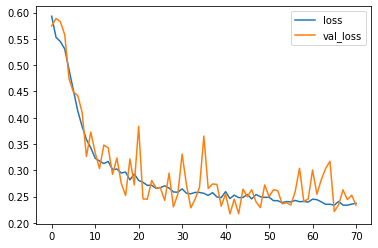

In [ ]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9731769561767578


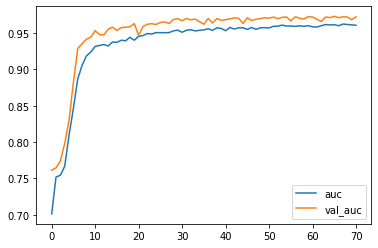

In [ ]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9200842380523682


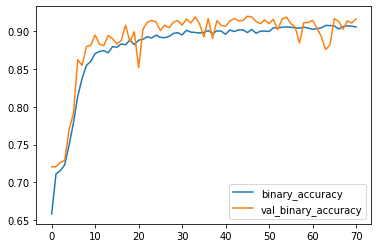

In [ ]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [ ]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.012179017066955566

In [ ]:
preds1 = top_50_nn.predict(val_X)
preds1

array([[0.91260344],
       [0.02085212],
       [0.41528523],
       ...,
       [0.36616087],
       [0.05954185],
       [0.9062793 ]], dtype=float32)

In [ ]:
len(preds1[preds1 <= 0.5])

13777

In [ ]:
len(preds1[preds1 > 0.5])

8385

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.912603
1,0.020852
2,0.415285
3,0.091382
4,0.747978


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_url,qty_hyphen_url,qty_slash_url,length_url,qty_dot_domain,qty_vowels_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_and_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,params_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects
0,0.912603,1,62575,0.000276,0.000000,0.000345,0.003517,0.000207,0.000345,0.001172,0.000069,0.000000,0.000000,0.000345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002345,0.000069,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000690,0.0,0.000007,0.000000,0.138820,0.037377,0.000138,0.000138,0.000069,0.989602,0.000000,0.000000
1,0.020852,0,38126,0.000078,0.000000,0.000000,0.001012,0.000078,0.000272,0.001012,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000098,0.786588,0.260471,0.009454,0.000039,0.000078,0.000039,0.559770,0.000039,0.000000
2,0.415285,0,1617,0.000138,0.000069,0.000069,0.002348,0.000138,0.000345,0.001312,0.000000,0.000069,0.000000,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001036,0.000000,0.000069,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000967,0.0,0.000073,0.921059,0.388661,0.014919,0.000138,0.000138,0.000345,0.018994,0.000069,0.000138
3,0.091382,0,8228,0.000041,0.000000,0.000000,0.000285,0.000041,0.000020,0.000285,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000050,0.948421,0.119534,0.021672,0.000020,0.000041,0.000020,0.292813,0.000020,0.000020
4,0.747978,1,55594,0.054944,0.000000,0.054944,0.769219,0.027472,0.109888,0.384610,0.027472,0.000000,0.027472,0.054944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384610,0.027472,0.000000,0.027472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274721,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.109888,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.000520,0,65294,0.000261,0.000000,0.000000,0.001480,0.000261,0.000261,0.001480,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000089,0.684142,0.658983,0.008618,0.000087,0.000174,0.000087,0.312430,0.000087,0.000087
22158,0.016039,0,10038,0.000134,0.000000,0.000000,0.001070,0.000134,0.000268,0.001070,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000010,0.891957,0.419925,0.166351,0.000134,0.000134,0.000334,0.020000,0.000067,0.000067
22159,0.366161,0,43642,0.000149,0.000000,0.000000,0.001710,0.000149,0.000520,0.001710,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000043,0.999761,0.000000,0.000000,0.000074,0.000149,0.000149,0.021711,0.000000,0.000000
22160,0.059542,0,73632,0.000048,0.000024,0.000000,0.000624,0.000048,0.000144,0.000624,0.000000,0.000000,0.000000,0.000000

In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]


# neural network on top 50 most important features per recursive feature elimination package [model as feature]

In [ ]:
y = full_df.iloc[:,-1]

features = ['qty_dot_url', 'qty_hyphen_url', 'qty_slash_url', 'length_url',
       'qty_dot_domain', 'qty_vowels_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory',
       'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'directory_length', 'qty_dot_file',
       'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
       'qty_questionmark_file', 'qty_equal_file', 'qty_at_file',
       'qty_and_file', 'qty_exclamation_file', 'qty_space_file',
       'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
       'qty_percent_file', 'file_length', 'params_length', 'time_response',
       'asn_ip', 'time_domain_activation', 'time_domain_expiration',
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects']
X = full_df[features]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_slash_url,length_url,qty_dot_domain,qty_vowels_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_and_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,params_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects
5676,0.000004,0.0,0.000004,0.000042,0.000004,0.000008,0.000038,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.999934,0.000591,0.000797,0.000004,0.000023,0.000008,0.011480,0.000004,0.000000
39002,0.000777,0.0,0.000000,0.003369,0.000777,0.000518,0.003369,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000063,0.730210,0.000000,0.680199,0.001036,0.001036,0.000518,0.064003,0.000259,0.000259
1732,0.000092,0.0,0.000000,0.000737,0.000092,0.000230,0.000737,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.698307,0.269674,0.016112,0.000046,0.000092,0.000046,0.662860,0.000000,0.000000
39668,0.000122,0.0,0.000000,0.001588,0.000122,0.000550,0.001588,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.859057,0.261792,0.005926,0.000061,0.000122,0.000244,0.439823,0.000000,0.000061
82035,0.000054,0.0,0.000000,0.000751,0.000054,0.000188,0.000751,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.795440,0.178787,0.007212,0.000027,0.000107,0.000107,0.579014,0.000000,0.000000


In [ ]:
tf.keras.backend.clear_session()

earlystopping = callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                         patience = 15, restore_best_weights = True)
                                         
def phish_nn_top50():
  model = keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[50]))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=50, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.20))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.40))
  model.add(tf.keras.layers.Dense(units=111, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_X, train_y, validation_split=0.30, batch_size= 175, epochs=50, callbacks = [earlystopping], workers=8)
  model.predict(val_X)
  model.evaluate(val_X, val_y)
  return model

In [ ]:
mod_top50 = KerasClassifier(build_fn=phish_nn_top50,
                        epochs=10,
                        batch_size=175)

In [ ]:
num_folds=5
kfold=StratifiedKFold(n_splits=num_folds, shuffle=True)

cv_results_top50 = cross_val_score(mod_top50,
                           X, y,
                           cv=kfold
                           )

Epoch 1/50
266/266 [==============================] - 2s 5ms/step - loss: 0.6203 - accuracy: 0.6551 - val_loss: 0.5781 - val_accuracy: 0.7224
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5605 - accuracy: 0.7075 - val_loss: 0.5820 - val_accuracy: 0.7257
Epoch 3/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5436 - accuracy: 0.7227 - val_loss: 0.5754 - val_accuracy: 0.7260
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5335 - accuracy: 0.7265 - val_loss: 0.5861 - val_accuracy: 0.7383
Epoch 5/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5157 - accuracy: 0.7386 - val_loss: 0.4971 - val_accuracy: 0.7695
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4762 - accuracy: 0.7718 - val_loss: 0.4675 - val_accuracy: 0.8101
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4231 - accuracy: 0.8133 - val_loss: 0.5076 - val_accuracy: 0.7901
Epoch 

In [ ]:
print(round(cv_results_top50.mean(), 4))

0.9093


In [ ]:
print(round(cv_results_top50.std(), 4))

0.0144


In [ ]:
cv_results_top50

array([0.9222222 , 0.91003948, 0.91499805, 0.91742343, 0.88166279])

In [ ]:
cv_top50_preds = cross_val_predict(mod_top50, X, y, cv=5)

Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6221 - accuracy: 0.6462 - val_loss: 0.5685 - val_accuracy: 0.7164
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5633 - accuracy: 0.7062 - val_loss: 0.5826 - val_accuracy: 0.7219
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5464 - accuracy: 0.7184 - val_loss: 0.5684 - val_accuracy: 0.7233
Epoch 4/50
266/266 [==============================] - 1s 4ms/step - loss: 0.5338 - accuracy: 0.7252 - val_loss: 0.5412 - val_accuracy: 0.7417
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5065 - accuracy: 0.7412 - val_loss: 0.4856 - val_accuracy: 0.7769
Epoch 6/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4564 - accuracy: 0.7827 - val_loss: 0.4167 - val_accuracy: 0.8245
Epoch 7/50
266/266 [==============================] - 1s 4ms/step - loss: 0.4054 - accuracy: 0.8232 - val_loss: 0.4384 - val_accuracy: 0.8493
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6245 - accuracy: 0.6527 - val_loss: 0.5785 - val_accuracy: 0.7206
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5616 - accuracy: 0.7082 - val_loss: 0.5573 - val_accuracy: 0.7238
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5470 - accuracy: 0.7183 - val_loss: 0.5646 - val_accuracy: 0.7312
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5280 - accuracy: 0.7289 - val_loss: 0.5216 - val_accuracy: 0.7572
Epoch 5/50
266/266 [==============================] - 2s 7ms/step - loss: 0.4754 - accuracy: 0.7735 - val_loss: 0.4378 - val_accuracy: 0.8155
Epoch 6/50
266/266 [==============================] - 2s 6ms/step - loss: 0.4241 - accuracy: 0.8130 - val_loss: 0.4338 - val_accuracy: 0.8279
Epoch 7/50
266/266 [==============================] - 2s 6ms/step - loss: 0.3913 - accuracy: 0.8348 - val_loss: 0.4290 - val_accuracy: 0.8673
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6242 - accuracy: 0.6489 - val_loss: 0.5734 - val_accuracy: 0.7208
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5600 - accuracy: 0.7023 - val_loss: 0.5902 - val_accuracy: 0.7226
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5453 - accuracy: 0.7175 - val_loss: 0.5490 - val_accuracy: 0.7269
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5382 - accuracy: 0.7215 - val_loss: 0.5500 - val_accuracy: 0.7348
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5205 - accuracy: 0.7336 - val_loss: 0.5040 - val_accuracy: 0.7626
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4748 - accuracy: 0.7715 - val_loss: 0.4227 - val_accuracy: 0.8068
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4232 - accuracy: 0.8097 - val_loss: 0.4542 - val_accuracy: 0.8467
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6295 - accuracy: 0.6459 - val_loss: 0.5666 - val_accuracy: 0.7189
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5560 - accuracy: 0.7054 - val_loss: 0.5608 - val_accuracy: 0.7259
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5510 - accuracy: 0.7105 - val_loss: 0.5554 - val_accuracy: 0.7307
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5361 - accuracy: 0.7225 - val_loss: 0.5461 - val_accuracy: 0.7370
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5153 - accuracy: 0.7316 - val_loss: 0.4830 - val_accuracy: 0.7745
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4671 - accuracy: 0.7703 - val_loss: 0.4639 - val_accuracy: 0.7982
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4286 - accuracy: 0.7939 - val_loss: 0.3914 - val_accuracy: 0.8302
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
266/266 [==============================] - 3s 6ms/step - loss: 0.6261 - accuracy: 0.6494 - val_loss: 0.5579 - val_accuracy: 0.7153
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5562 - accuracy: 0.7012 - val_loss: 0.5696 - val_accuracy: 0.7216
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5480 - accuracy: 0.7140 - val_loss: 0.5652 - val_accuracy: 0.7276
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5403 - accuracy: 0.7178 - val_loss: 0.5402 - val_accuracy: 0.7344
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.5251 - accuracy: 0.7263 - val_loss: 0.5287 - val_accuracy: 0.7451
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4846 - accuracy: 0.7575 - val_loss: 0.5061 - val_accuracy: 0.7765
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.4473 - accuracy: 0.7866 - val_loss: 0.4414 - val_accuracy: 0.8064
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm_top50 = confusion_matrix(y, cv_top50_preds)
print(cm_top50)

[[52138  5862]
 [ 2262 28385]]
